# FOREX Trading Strategy

-*- coding: utf-8 -*- """ Created on Wed May 18 12:00:50 2022 @author: Eva Cheng / Maxime Caron (DMF)"""

In the scope of our Machine Learning class, we have to implement a trading strategy based on our knowledge about machine learning. This code has been created by Eva Cheng and Maxime Caron from the MSc Data Management for Finance program. Our strategy is based on "predicting the direction of variation" of the market based on the past returns and variation of the FOREX pair but also from other pairs. In case we have time to implement more, we will try to use the Moving Average as well but our strategy is already very complete. Sentiment analysis could have been an option but it can be a very long process.

## I. Initial configurations
As all codes, we have to set the libraries and the global variables we are willing to use for our analysis. The global variables are to be modified according to the user needs and desire. We also set the functions that may be used in further analysis.
### a. Libraries

In [107]:
# Using MetaTrader5
import MetaTrader5 as mt5
# Related to date and time
import datetime
from datetime import date
import time
import pytz
# Important libraries used for data analysis in general
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# Non exhaustive libraries used in machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
# Configuration
import warnings
import os

### b. Activating MetaTrader5

In [2]:
# Disable warnings
warnings.filterwarnings("ignore")
# Not very useful but it's the rigourous way of processing
os.chdir("C:/Users/33652/Desktop/Cours M2/Semester 2/Machine Learning")
# This will automatically launch MetaTrader5
if not mt5.initialize():
    print("initialize() failed, error code =", mt5.last_error())
    quit()

### c. Global Variables that can be changed

In [103]:
# Date that does not require to be changed
starting_date = date.today()
from_time = datetime.datetime(starting_date.year, 
                              starting_date.month, starting_date.day)
from_time = from_time.astimezone(pytz.timezone('Europe/Berlin'))

# Related to decision about the trade, what and how much, at which level, what quantity, what frequency
threshold = 10
pair_trade = 'EURUSD'
lot_quantity = 1
amount_invested=1000
number_of_trade = 20
infinite_trade = False
point_trade = mt5.symbol_info(pair_trade).point
timeframe = mt5.TIMEFRAME_M2

# Related to peers and other FOREX pairs
other_pair_1 = 'GBPUSD'
other_pair_2 = 'USDJPY'
other_pair_3 = 'USDCAD'
other_pair_4 = 'AUDUSD'
other_pair_5 = 'USDCHF'
other_pair_6 = 'USDHKD'
point_1 = mt5.symbol_info(other_pair_1).point
point_2 = mt5.symbol_info(other_pair_2).point
point_3 = mt5.symbol_info(other_pair_3).point
point_4 = mt5.symbol_info(other_pair_4).point
point_5 = mt5.symbol_info(other_pair_5).point
point_6 = mt5.symbol_info(other_pair_6).point

# Choices specific for the strategy and precision
standard_lot_value = 100000
leverage=100
magic = 806
number_of_records_past = 10000
percentage_of_training = 0.7
std_dev = 0.5


### d. Functions
The functions used here are meant to be to make the understanding easier and to avoid repeating the same part of code that make the code heavier (calculations or other processes in several steps)

In [4]:
# The following function sends an order to MetaTrader, with a symbol, a certain quantity, a type of order
# but also the magic number which is the reference of orders we will send and threshold for stop loss or take profit

def send_order(symbol,quantity,order,magic_number,th, point):
    if order == 'BUY': 
        trade_type = mt5.ORDER_TYPE_BUY
        price = mt5.symbol_info_tick(symbol).ask
        sl = mt5.symbol_info_tick(symbol).ask-th*point
        tp = mt5.symbol_info_tick(symbol).ask+th*point
    else : 
        trade_type = mt5.ORDER_TYPE_SELL
        price = mt5.symbol_info_tick(symbol).bid
        sl = mt5.symbol_info_tick(symbol).bid+th*point
        tp = mt5.symbol_info_tick(symbol).bid-th*point
    request = {
    "action": mt5.TRADE_ACTION_DEAL,
    "symbol": symbol,
    "volume": float(quantity),
    "type": trade_type,
    "price":  price,
    "sl": sl,
    "tp": tp,
    "magic": magic_number,
    "comment": "Final Project Strat",
    "type_time": mt5.ORDER_TIME_GTC,
    "type_filling": mt5.ORDER_FILLING_IOC,
    }
    result =  mt5.order_send(request)
    if result.retcode != mt5.TRADE_RETCODE_DONE:
        print("\nFailed to send order :(")
    else:
        print("\nOrder successfully placed!")
        if order == 'BUY': 
            print("BUY order sent !")
        else : 
            print("SELL order sent !")
        return 1
    return 0

# The following is about getting the dataframe with the closing FOREX rate. We created 6 shifts (so we have the close at t, t-1,
# t-2, t-3, t-4, t-5 and t-6 and therefore we can get the direction of variation of t, t-1, t-2, t-3, t-4, t-5)
def getData_rate(symb, timeframe, number_of_records):
    # Copy the last n records from MetaTrader
    rate_frame = pd.DataFrame(mt5.copy_rates_from_pos(symb, timeframe, 0, number_of_records))
    # Set the time as the index
    rate_frame['time'] = pd.to_datetime(rate_frame['time'], unit='s')   
    rate_frame.index=pd.to_datetime(rate_frame['time'])
    # Keep only the close rate
    rate_frame = rate_frame[['close']]
    rate_frame.rename(columns={'close':symb+ " close"}, inplace=True)
    rate_frame[symb+" t-1"] = rate_frame[symb+ " close"].shift()
    rate_frame[symb+" t-2"] = rate_frame[symb+ " close"].shift(2)
    rate_frame[symb+" t-3"] = rate_frame[symb+ " close"].shift(3)
    rate_frame[symb+" t-4"] = rate_frame[symb+ " close"].shift(4)
    rate_frame[symb+" t-5"] = rate_frame[symb+ " close"].shift(5)
    rate_frame[symb+" t-6"] = rate_frame[symb+ " close"].shift(6)
    # The first few records are not really useful
    rate_frame.dropna(inplace=True)
    return rate_frame

# So this one takes the dataframe from the previous function in parameter and it tells how the rate changed from t-1
def getData_signals(symb, rate_frame, point, thresh):
    signals = pd.DataFrame(None)
    signals[symb+ ' Close'] = rate_frame.iloc[:,0]
    for i in range (5):
        # For all t-1, if there a significant increase (decrease) from t-2 to t-1 then the signal is 1 (-1), else 0
        signals[str(symb+" t-"+str(i+1))] = 0
        signals.loc[rate_frame[symb+" t-"+str(i+1)] - rate_frame[symb+" t-"+str(i+2)]
                    >=point*thresh, str(symb+" t-"+str(i+1))] = 1
        signals.loc[rate_frame[symb+" t-"+str(i+1)] - rate_frame[symb+" t-"+str(i+2)]
                    <=-point*thresh, str(symb+" t-"+str(i+1))] = -1
    return signals

# Same but with positive signals only because in the class we saw something with positive signal only so we can try with 
# Positive signal and try to compare
def getdata_postive(symb, signals_data):
    positive_signals = pd.DataFrame(None)
    positive_signals[symb+' Close'] = signals_data.iloc[:,0]
    for i in range (5):
        positive_signals[str(symb+" t-"+str(i+1))] = 0
        positive_signals.loc[signals_data[symb+" t-"+str(i+1)]==1, str(symb+" t-"+str(i+1))] = 1
    return positive_signals

# Function that returns the target and the direction of variation at t, this is what we are willing to predict in our analysis
def create_result(symb, signals_data, point, threshold):
    result_class = pd.DataFrame(None)
    result_class[symb+ ' Close'] = signals_data.iloc[:,0]
    result_class['Class'] = 'Neutral'
    # If significant change, it is recorded as Increase or Decrease
    result_class.loc[signals_data.iloc[:,0] - signals_data.iloc[:,0].shift() <=-threshold*point, 'Class'] = 'Decrease'
    result_class.loc[signals_data.iloc[:,0] - signals_data.iloc[:,0].shift() >=threshold*point, 'Class'] = 'Increase'
    return pd.DataFrame(result_class.iloc[:,1])

# Return the features only of a close rate (eliminate the close price)
def feature_close(lagged_close_rates):
    return lagged_close_rates.iloc[:,1:6]

# Same with the signals and positive signal
def signals_features(signals):
    return signals.iloc[:,1:]

def positive_signal_features(positive_signals):
    return positive_signals.iloc[:,1:]
 
# Calculate the gain of an order (offer price is the price at which it is sold : the selling price or the limit of a buy order)
# The demand is the buying price or th price at which (limit) the sell price is executed. Standard lot price and quantity
def calculate_gain(offer_price, demand_price, lot, lot_q):
    return (offer_price-demand_price)*lot*lot_q*1/offer_price

## II. Creation of the dataset
The longest process but also the most important is the one that relates to the creation of the dataset (features and targets), they also require to be clean, and they should be created properly following proper format otherwise, we would not be able to use pursue our analysis. 
### a. Collecting the data from MetaTrader

In [5]:
# Closing rates
data_close = getData_rate(pair_trade, timeframe, number_of_records_past)
# This one will be used later but it is initialized here because we want to have the same time record as the data
frame_price = pd.DataFrame(mt5.copy_rates_from_pos(pair_trade, timeframe, 0, number_of_records_past))
data_close.head()

,EURUSD close,EURUSD t-1,EURUSD t-2,EURUSD t-3,EURUSD t-4,EURUSD t-5,EURUSD t-6
time,,,,,,,
2022-05-05 13:46:00,1.05944,1.05928,1.05932,1.05945,1.05985,1.05983,1.06012
2022-05-05 13:48:00,1.05913,1.05944,1.05928,1.05932,1.05945,1.05985,1.05983
2022-05-05 13:50:00,1.05884,1.05913,1.05944,1.05928,1.05932,1.05945,1.05985
2022-05-05 13:52:00,1.05913,1.05884,1.05913,1.05944,1.05928,1.05932,1.05945
2022-05-05 13:54:00,1.05898,1.05913,1.05884,1.05913,1.05944,1.05928,1.05932


In [6]:
# Signals (telling how the rates are evolving)
data_signals = getData_signals(pair_trade, data_close, point_trade, threshold)
data_signals.head()

,EURUSD Close,EURUSD t-1,EURUSD t-2,EURUSD t-3,EURUSD t-4,EURUSD t-5
time,,,,,,
2022-05-05 13:46:00,1.05944,0,-1,-1,0,-1
2022-05-05 13:48:00,1.05913,1,0,-1,-1,0
2022-05-05 13:50:00,1.05884,-1,1,0,-1,-1
2022-05-05 13:52:00,1.05913,-1,-1,1,0,-1
2022-05-05 13:54:00,1.05898,1,-1,-1,1,0


In [7]:
# Positive signals
data_signals_positive = getdata_postive(pair_trade, data_signals)
data_signals_positive.head()

,EURUSD Close,EURUSD t-1,EURUSD t-2,EURUSD t-3,EURUSD t-4,EURUSD t-5
time,,,,,,
2022-05-05 13:46:00,1.05944,0,0,0,0,0
2022-05-05 13:48:00,1.05913,1,0,0,0,0
2022-05-05 13:50:00,1.05884,0,1,0,0,0
2022-05-05 13:52:00,1.05913,0,0,1,0,0
2022-05-05 13:54:00,1.05898,1,0,0,1,0


### b. Creating the Target dataframe

In [8]:
# This represents how the close is evolving at a specific stage
pair_trade_result = create_result(pair_trade, data_signals, point_trade, threshold)
pair_trade_result.head()

,Class
time,
2022-05-05 13:46:00,Neutral
2022-05-05 13:48:00,Decrease
2022-05-05 13:50:00,Decrease
2022-05-05 13:52:00,Increase
2022-05-05 13:54:00,Decrease


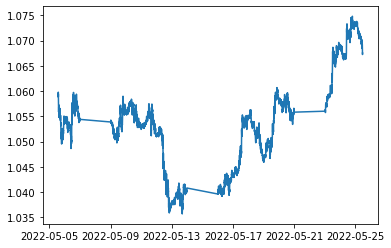

In [9]:
# Let's display the rates over time
plt.clf()
plt.plot(data_close.iloc[:,0])
plt.show()

### c. Creating the features
Here would be different features because we would like to focus our analysis on the EURUSD pair first and complete the models with other peers' forex pairs to make it more accurate.

In [10]:
# For the EURUSD FOREX pairs we are basically removing the close price and keeping the variables only
df_lag_close = feature_close(data_close)
df_signals_features = signals_features(data_signals)
df_positive_signal_features = positive_signal_features(data_signals_positive)

In [11]:
# Let's do the same for other FOREX pairs 
### GBP/USD
# Collection of data from MetaTrader
gbp_usd_data = getData_rate(other_pair_1, timeframe, number_of_records_past)
gbp_usd_signals = getData_signals(other_pair_1, gbp_usd_data, point_1, threshold)
gbp_usd_signals_positive = positive_signal_features(getdata_postive(other_pair_1, gbp_usd_signals))
# Remove other columns
gbp_usd_data = feature_close(gbp_usd_data)
gbp_usd_signals = signals_features(gbp_usd_signals)

### USD/JPY
# Collection of data from MetaTrader
usd_jpy_data = getData_rate(other_pair_2, timeframe, number_of_records_past)
usd_jpy_signals = getData_signals(other_pair_2, usd_jpy_data, point_2, threshold)
usd_jpy_signals_positive = positive_signal_features(getdata_postive(other_pair_2, usd_jpy_signals))
# Remove
usd_jpy_data = feature_close(usd_jpy_data)
usd_jpy_signals = signals_features(usd_jpy_signals)

### USD/CAD
# Collection of data from MetaTrader
usd_cad_data = getData_rate(other_pair_3, timeframe, number_of_records_past)
usd_cad_signals = getData_signals(other_pair_3, usd_cad_data, point_3, threshold)
usd_cad_signals_positive = positive_signal_features(getdata_postive(other_pair_3, usd_cad_signals))
# Remove
usd_cad_data = feature_close(usd_cad_data)
usd_cad_signals = signals_features(usd_cad_signals)

### AUD/USD
# Collection of data from MetaTrader
aud_usd_data = getData_rate(other_pair_4, timeframe, number_of_records_past)
aud_usd_signals = getData_signals(other_pair_4, aud_usd_data, point_4, threshold)
aud_usd_signals_positive = positive_signal_features(getdata_postive(other_pair_4, aud_usd_signals))
# Remove
aud_usd_data = feature_close(aud_usd_data)
aud_usd_signals = signals_features(aud_usd_signals)

### USD/CHF
# Collection of data from MetaTrader
usd_chf_data = getData_rate(other_pair_5, timeframe, number_of_records_past)
usd_chf_signals = getData_signals(other_pair_5, usd_chf_data, point_5, threshold)
usd_chf_signals_positive = positive_signal_features(getdata_postive(other_pair_5, usd_chf_signals))
# Remove
usd_chf_data = feature_close(usd_chf_data)
usd_chf_signals = signals_features(usd_chf_signals)

### USD/HKD
# Collection of data from MetaTrader
usd_hkd_data = getData_rate(other_pair_6, timeframe, number_of_records_past)
usd_hkd_signals = getData_signals(other_pair_6, usd_hkd_data, point_6, threshold)
usd_hkd_signals_positive = positive_signal_features(getdata_postive(other_pair_6, usd_hkd_signals))
# Remove
usd_hkd_data = feature_close(usd_hkd_data)
usd_hkd_signals = signals_features(usd_hkd_signals)

After collecting the data, we are willing to create a dataframe with all the currencies so we can get a big dataframe with all the different pairs, that will represent the features.

In [12]:
# Closing rates
other_forex_data = pd.concat([df_lag_close, gbp_usd_data,usd_jpy_data,usd_cad_data,
                              aud_usd_data,usd_chf_data,usd_hkd_data], axis = 1)
other_forex_data.tail()

,EURUSD t-1,EURUSD t-2,EURUSD t-3,EURUSD t-4,EURUSD t-5,GBPUSD t-1,GBPUSD t-2,GBPUSD t-3,GBPUSD t-4,GBPUSD t-5,...,USDCHF t-1,USDCHF t-2,USDCHF t-3,USDCHF t-4,USDCHF t-5,USDHKD t-1,USDHKD t-2,USDHKD t-3,USDHKD t-4,USDHKD t-5
time,,,,,,,,,,,,,,,,,,,,,
2022-05-25 11:00:00,1.06843,1.06836,1.06854,1.06870,1.06900,NaN,NaN,NaN,NaN,NaN,...,0.96144,0.96161,0.96159,0.96155,0.96154,7.84935,7.84922,7.84922,7.84922,7.84920
2022-05-25 11:02:00,1.06833,1.06843,1.06836,1.06854,1.06870,NaN,NaN,NaN,NaN,NaN,...,0.96153,0.96144,0.96161,0.96159,0.96155,7.84940,7.84935,7.84922,7.84922,7.84922
2022-05-25 11:04:00,1.06726,1.06833,1.06843,1.06836,1.06854,NaN,NaN,NaN,NaN,NaN,...,0.96209,0.96153,0.96144,0.96161,0.96159,7.84941,7.84940,7.84935,7.84922,7.84922
2022-05-25 11:06:00,1.06745,1.06726,1.06833,1.06843,1.06836,NaN,NaN,NaN,NaN,NaN,...,0.96214,0.96209,0.96153,0.96144,0.96161,7.84945,7.84941,7.84940,7.84935,7.84922
2022-05-25 11:08:00,1.06725,1.06745,1.06726,1.06833,1.06843,NaN,NaN,NaN,NaN,NaN,...,0.96215,0.96214,0.96209,0.96153,0.96144,7.84943,7.84945,7.84941,7.84940,7.84935


In [13]:
# Creating the signals
other_forex_signals = pd.concat([df_signals_features, gbp_usd_signals,usd_jpy_signals,usd_cad_signals,
                              aud_usd_signals,usd_chf_signals,usd_hkd_signals], axis = 1)
other_forex_signals.tail()

,EURUSD t-1,EURUSD t-2,EURUSD t-3,EURUSD t-4,EURUSD t-5,GBPUSD t-1,GBPUSD t-2,GBPUSD t-3,GBPUSD t-4,GBPUSD t-5,...,USDCHF t-1,USDCHF t-2,USDCHF t-3,USDCHF t-4,USDCHF t-5,USDHKD t-1,USDHKD t-2,USDHKD t-3,USDHKD t-4,USDHKD t-5
time,,,,,,,,,,,,,,,,,,,,,
2022-05-25 11:00:00,0.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,...,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-05-25 11:02:00,0.0,0.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-05-25 11:04:00,-1.0,0.0,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-05-25 11:06:00,1.0,-1.0,0.0,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-05-25 11:08:00,-1.0,1.0,-1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0


In [14]:
# Creating the positive signals (in futher calculations, we will notice that they are not useful)
other_forex_signals_pos = pd.concat([df_positive_signal_features, gbp_usd_signals_positive,usd_jpy_signals_positive,
                                     usd_cad_signals_positive, aud_usd_signals_positive,
                                     usd_chf_signals_positive,usd_hkd_signals_positive], axis = 1)
other_forex_signals_pos.tail()

,EURUSD t-1,EURUSD t-2,EURUSD t-3,EURUSD t-4,EURUSD t-5,GBPUSD t-1,GBPUSD t-2,GBPUSD t-3,GBPUSD t-4,GBPUSD t-5,...,USDCHF t-1,USDCHF t-2,USDCHF t-3,USDCHF t-4,USDCHF t-5,USDHKD t-1,USDHKD t-2,USDHKD t-3,USDHKD t-4,USDHKD t-5
time,,,,,,,,,,,,,,,,,,,,,
2022-05-25 11:00:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-05-25 11:02:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-05-25 11:04:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-05-25 11:06:00,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-05-25 11:08:00,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


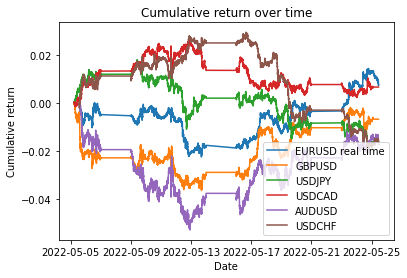

In [15]:
# Plot the cummulative return of all the pairs so we can see how it is evolving, but with EURUSD in real time and the other t-1
plt.clf()
plt.plot((data_close['EURUSD close'].pct_change()+1).cumprod() -1, label = 'EURUSD real time')
plt.plot((other_forex_data['GBPUSD t-1'].pct_change()+1).cumprod() -1, label = 'GBPUSD')
plt.plot((other_forex_data['USDJPY t-1'].pct_change()+1).cumprod() -1, label = 'USDJPY')
plt.plot((other_forex_data['USDCAD t-1'].pct_change()+1).cumprod() -1, label = 'USDCAD')
plt.plot((other_forex_data['AUDUSD t-1'].pct_change()+1).cumprod() -1, label = 'AUDUSD')
plt.plot((other_forex_data['USDCHF t-1'].pct_change()+1).cumprod() -1, label = 'USDCHF')
plt.title("Cumulative return over time")
plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.legend()
plt.show()

From the observations we made, we can see that in the data at t-1, if USDCHF, USDCAD, USDJPY start to increase. he data in real time will decrease, and it is the reverse for GBPUSD and AUDUSD, and it can be easier to track AUDUSD because the fluctuations are wider.

### d. Cleaning the data 
Since we collected FOREX from different countries and since markets do not open all at the same time, are have to rebalance the data, eliminate the rows where some data do not exist otherwise it can be a big problem and we may have some NULL values so predictions will not be possible.

In [16]:
# We start by dropping the NA and NaN values from the FOREX data
other_forex_data.dropna(inplace=True)
other_forex_signals.dropna(inplace=True)
other_forex_signals_pos.dropna(inplace=True)

In [17]:
# Reallocating the final value of the EURUSD to the EURUSD dataset (so some rows have been removed)
df_lag_close = other_forex_data.iloc[:, :5]
df_lag_close.head()

,EURUSD t-1,EURUSD t-2,EURUSD t-3,EURUSD t-4,EURUSD t-5
time,,,,,
2022-05-05 13:46:00,1.05928,1.05932,1.05945,1.05985,1.05983
2022-05-05 13:48:00,1.05944,1.05928,1.05932,1.05945,1.05985
2022-05-05 13:50:00,1.05913,1.05944,1.05928,1.05932,1.05945
2022-05-05 13:52:00,1.05884,1.05913,1.05944,1.05928,1.05932
2022-05-05 13:54:00,1.05913,1.05884,1.05913,1.05944,1.05928


In [18]:
# Same for the signal
df_signals_features = other_forex_signals.iloc[:, :5]
df_signals_features.head()

,EURUSD t-1,EURUSD t-2,EURUSD t-3,EURUSD t-4,EURUSD t-5
time,,,,,
2022-05-05 13:46:00,0.0,-1.0,-1.0,0.0,-1.0
2022-05-05 13:48:00,1.0,0.0,-1.0,-1.0,0.0
2022-05-05 13:50:00,-1.0,1.0,0.0,-1.0,-1.0
2022-05-05 13:52:00,-1.0,-1.0,1.0,0.0,-1.0
2022-05-05 13:54:00,1.0,-1.0,-1.0,1.0,0.0


In [19]:
# And the positive signals
data_signals_positive = other_forex_signals_pos.iloc[:, :5]
data_signals_positive.head()

,EURUSD t-1,EURUSD t-2,EURUSD t-3,EURUSD t-4,EURUSD t-5
time,,,,,
2022-05-05 13:46:00,0.0,0.0,0.0,0.0,0.0
2022-05-05 13:48:00,1.0,0.0,0.0,0.0,0.0
2022-05-05 13:50:00,0.0,1.0,0.0,0.0,0.0
2022-05-05 13:52:00,0.0,0.0,1.0,0.0,0.0
2022-05-05 13:54:00,1.0,0.0,0.0,1.0,0.0


In [20]:
# Now we have to balance the target dataframe too since we eliminated some rows
# Temporary dataframe that help balancing
df = pd.concat([df_lag_close, pair_trade_result],axis = 1)
df.dropna(inplace = True)
df_lag_close = pd.DataFrame(df.iloc[:,:-1])
pair_trade_result = pd.DataFrame(df.iloc[:,-1])
pair_trade_result['Close'] = data_close['EURUSD close']
# We can make the classes quantitative as well (it will be useful for further calculations)
# Make the target variable quantitative 
pair_trade_result['Quantitative class'] = 0
pair_trade_result['Quantitative class'].loc[pair_trade_result['Class'] == 'Increase'] = 1
pair_trade_result['Quantitative class'].loc[pair_trade_result['Class'] == 'Neutral'] = 0
pair_trade_result['Quantitative class'].loc[pair_trade_result['Class'] == 'Decrease'] = -1
pair_trade_result.dropna(inplace = True)
pair_trade_result.head()

,Class,Close,Quantitative class
time,,,
2022-05-05 13:46:00,Neutral,1.05944,0
2022-05-05 13:48:00,Decrease,1.05913,-1
2022-05-05 13:50:00,Decrease,1.05884,-1
2022-05-05 13:52:00,Increase,1.05913,1
2022-05-05 13:54:00,Decrease,1.05898,-1


## III. Separating the dataset into testing and training set
In order to test our strategy and do a back test, evaluate the relevance of our models, we are going to split the dataset into training and testing sets, create the features and the targets. (Can be returns or classes actually).

In [21]:
# Setting the variables X and Y in order to make it clear.
# Closing rate
X_EURUSD_close = df_lag_close
X_WORLD_close = other_forex_data
Y_EURSD_close = pair_trade_result['Close']
# Returns 
X_EURUSD_returns = X_EURUSD_close.pct_change()
Y_EURUSD_returns = Y_EURSD_close.pct_change()
X_WORLD_returns = X_WORLD_close.pct_change()
# Dropping the NA and NaN values 
X_EURUSD_returns.dropna(inplace = True)
Y_EURUSD_returns.dropna(inplace = True)
X_WORLD_returns.dropna(inplace = True)
# Signals data sets
X_EURUSD_signal = df_signals_features
X_WORLD_signal = other_forex_signals
X_EURUSD_pos_sign = df_positive_signal_features
X_WORLD_pos_sign = other_forex_signals_pos

Since we have the X and the Y for the analysis, we can now split the data into training and testing sets as every machine learning analysis. To avoid bias due to the time, we are going to split the datasets randomly.

In [22]:
# Separate between test and training sets. Take a random sample.
X_EURUSD_returns_train = X_EURUSD_returns.sample(frac = percentage_of_training)
# Sort the dataset by date to make the analysis consistent
X_EURUSD_returns_train.sort_index(inplace = True)
# Taking the records that are not in the training set as the testing set and sorting the dataset
X_EURUSD_returns_test = X_EURUSD_returns.loc[set(X_EURUSD_returns.index) - set(X_EURUSD_returns_train.index)]
X_EURUSD_returns_test.sort_index(inplace = True)
X_EURUSD_returns_test.head()


,EURUSD t-1,EURUSD t-2,EURUSD t-3,EURUSD t-4,EURUSD t-5
time,,,,,
2022-05-05 14:04:00,-0.000651,-0.000208,0.000378,0.000378,-0.000142
2022-05-05 14:10:00,-0.000198,-0.000453,0.000548,-0.000651,-0.000208
2022-05-05 14:14:00,-0.000519,0.000397,-0.000198,-0.000453,0.000548
2022-05-05 14:20:00,-0.000463,0.000198,-0.000312,-0.000519,0.000397
2022-05-05 14:22:00,0.000000,-0.000463,0.000198,-0.000312,-0.000519


In [23]:
# Same for the world dataset with the same index as the one from the previous dataset
X_WORLD_returns_train = X_WORLD_returns[X_WORLD_returns.index.isin(X_EURUSD_returns_train.index)]
X_WORLD_returns_train.sort_index(inplace = True)
X_WORLD_returns_test = X_WORLD_returns.loc[set(X_WORLD_returns.index) - set(X_WORLD_returns_train.index)]
X_WORLD_returns_test.sort_index(inplace = True)
X_WORLD_returns_test.head()

,EURUSD t-1,EURUSD t-2,EURUSD t-3,EURUSD t-4,EURUSD t-5,GBPUSD t-1,GBPUSD t-2,GBPUSD t-3,GBPUSD t-4,GBPUSD t-5,...,USDCHF t-1,USDCHF t-2,USDCHF t-3,USDCHF t-4,USDCHF t-5,USDHKD t-1,USDHKD t-2,USDHKD t-3,USDHKD t-4,USDHKD t-5
time,,,,,,,,,,,,,,,,,,,,,
2022-05-05 14:04:00,-0.000651,-0.000208,0.000378,0.000378,-0.000142,-0.002537,-0.000925,-0.000032,0.000096,0.000056,...,0.000430,0.000297,-0.000235,-0.000215,0.000215,0.000001,-0.000003,0.000003,-0.000003,0.000001
2022-05-05 14:10:00,-0.000198,-0.000453,0.000548,-0.000651,-0.000208,-0.000728,-0.001175,0.000408,-0.002537,-0.000925,...,-0.000358,-0.000041,-0.000532,0.000430,0.000297,0.000000,0.000003,-0.000001,0.000001,-0.000003
2022-05-05 14:14:00,-0.000519,0.000397,-0.000198,-0.000453,0.000548,-0.000769,-0.000505,-0.000728,-0.001175,0.000408,...,0.000113,0.000205,-0.000358,-0.000041,-0.000532,-0.000004,0.000004,0.000000,0.000003,-0.000001
2022-05-05 14:20:00,-0.000463,0.000198,-0.000312,-0.000519,0.000397,-0.000449,0.000449,-0.000778,-0.000769,-0.000505,...,0.000266,0.000194,0.000307,0.000113,0.000205,-0.000031,0.000001,0.000027,-0.000004,0.000004
2022-05-05 14:22:00,0.000000,-0.000463,0.000198,-0.000312,-0.000519,-0.000482,-0.000449,0.000449,-0.000778,-0.000769,...,0.000000,0.000266,0.000194,0.000307,0.000113,0.000004,-0.000031,0.000001,0.000027,-0.000004


In [24]:
# And the target
Y_EURUSD_returns_train = Y_EURUSD_returns[Y_EURUSD_returns.index.isin(X_EURUSD_returns_train.index)]
Y_EURUSD_returns_train.sort_index(inplace = True)
Y_EURUSD_returns_test = Y_EURUSD_returns.loc[set(Y_EURUSD_returns.index) - set(Y_EURUSD_returns_train.index)]
Y_EURUSD_returns_test.sort_index(inplace = True)
Y_EURUSD_returns_test.head()

time
2022-05-05 14:04:00    0.000548
2022-05-05 14:10:00    0.000397
2022-05-05 14:14:00   -0.000312
2022-05-05 14:20:00    0.000000
2022-05-05 14:22:00   -0.001002
Name: Close, dtype: float64

From the output data frames of the testing sets we made sure that the indexes are the same and that the analysis will be consistent (since we have the same index for the X and Y). Let's do the same for the signal datasets and positive signal dataset.

In [25]:
# EURUSD
X_EURUSD_signal_train = X_EURUSD_signal[X_EURUSD_signal.index.isin(X_EURUSD_returns_train.index)]
X_EURUSD_signal_train.sort_index(inplace = True)
X_EURUSD_pos_sign_train = X_EURUSD_pos_sign[X_EURUSD_pos_sign.index.isin(X_EURUSD_returns_train.index)]
X_EURUSD_pos_sign_train.sort_index(inplace = True)
X_EURUSD_pos_sign_train.head()

,EURUSD t-1,EURUSD t-2,EURUSD t-3,EURUSD t-4,EURUSD t-5
time,,,,,
2022-05-05 13:48:00,1,0,0,0,0
2022-05-05 13:50:00,0,1,0,0,0
2022-05-05 13:52:00,0,0,1,0,0
2022-05-05 13:54:00,1,0,0,1,0
2022-05-05 13:56:00,0,1,0,0,1


In [26]:
# WORLD dataset
X_WORLD_signal_train = X_WORLD_signal[X_WORLD_signal.index.isin(X_EURUSD_returns_train.index)]
X_WORLD_signal_train.sort_index(inplace = True)
X_WORLD_pos_sign_train = X_WORLD_pos_sign[X_WORLD_pos_sign.index.isin(X_EURUSD_returns_train.index)]
X_WORLD_pos_sign_train.sort_index(inplace = True)
X_WORLD_pos_sign_train.head()

,EURUSD t-1,EURUSD t-2,EURUSD t-3,EURUSD t-4,EURUSD t-5,GBPUSD t-1,GBPUSD t-2,GBPUSD t-3,GBPUSD t-4,GBPUSD t-5,...,USDCHF t-1,USDCHF t-2,USDCHF t-3,USDCHF t-4,USDCHF t-5,USDHKD t-1,USDHKD t-2,USDHKD t-3,USDHKD t-4,USDHKD t-5
time,,,,,,,,,,,,,,,,,,,,,
2022-05-05 13:48:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-05-05 13:50:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-05 13:52:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-05-05 13:54:00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-05-05 13:56:00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Same for the testing datasets
X_EURUSD_signal_test = X_EURUSD_signal.loc[set(X_EURUSD_signal.iloc[1:,:].index) - set(X_EURUSD_signal_train.index)]
X_EURUSD_signal_test.sort_index(inplace = True)
X_EURUSD_pos_sign_test = X_EURUSD_pos_sign.loc[set(X_EURUSD_signal.iloc[1:,:].index) - set(X_EURUSD_signal_train.index)]
X_EURUSD_pos_sign_test.sort_index(inplace = True)
# WORLD
X_WORLD_signal_test = X_WORLD_signal.loc[set(X_EURUSD_signal.iloc[1:,:].index) - set(X_EURUSD_signal_train.index)]
X_WORLD_signal_test.sort_index(inplace = True)
X_WORLD_pos_sign_test = X_WORLD_pos_sign.loc[set(X_EURUSD_signal.iloc[1:,:].index) - set(X_EURUSD_signal_train.index)]
X_WORLD_pos_sign_test.sort_index(inplace = True)

In [28]:
# Creating the target data
Y_EURUSD_class_train = pair_trade_result['Class'][pair_trade_result['Class'].index.isin(X_EURUSD_returns_train.index)]
Y_EURUSD_q_class_train = pair_trade_result['Quantitative class'][pair_trade_result['Quantitative class'].index.isin(
    X_EURUSD_returns_train.index)]
Y_EURUSD_class_test = pair_trade_result['Class'][set(pair_trade_result.iloc[1:,0].index) - set(Y_EURUSD_class_train.index)]
Y_EURUSD_q_class_test = pair_trade_result['Quantitative class'][set(pair_trade_result.iloc[1:,2].index) 
                                                                - set(Y_EURUSD_q_class_train.index)]
# Use forex at t-1 to counter over fitting
X_t_1_forex_train = X_WORLD_signal_train[['EURUSD t-1','GBPUSD t-1', 'USDJPY t-1', 'USDCAD t-1', 
                                          'AUDUSD t-1', 'USDCHF t-1', 'USDHKD t-1']]
X_t_1_forex_test = X_WORLD_signal_test[['EURUSD t-1','GBPUSD t-1', 'USDJPY t-1', 'USDCAD t-1', 
                                        'AUDUSD t-1', 'USDCHF t-1', 'USDHKD t-1']]
Y_EURUSD_class_test.head()

time
2022-05-20 06:52:00    Increase
2022-05-11 06:04:00     Neutral
2022-05-13 17:38:00    Increase
2022-05-10 09:38:00    Increase
2022-05-11 04:10:00    Decrease
Name: Class, dtype: object

<Figure size 432x288 with 0 Axes>

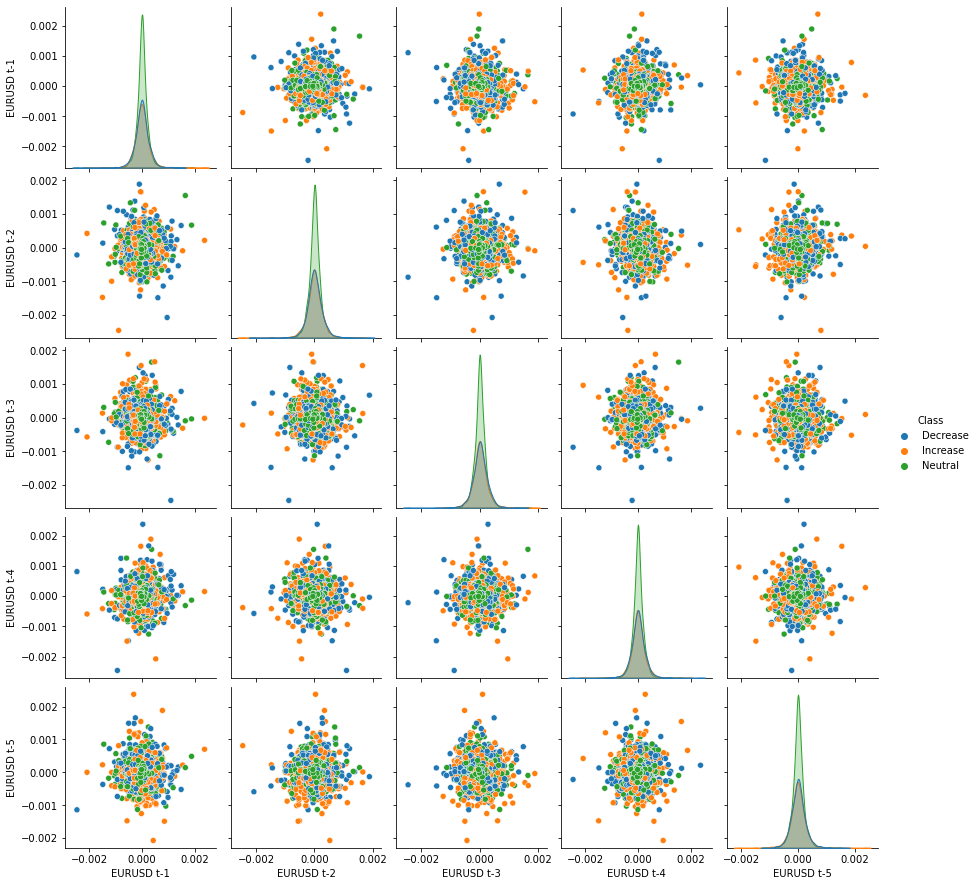

In [29]:
# Let us create a pair plot to see whether we can get a relationship among the variables or some clusters (If so we can use PCA)
# Pairplot
plt.clf()
sns.pairplot(pd.concat([X_EURUSD_returns_train, Y_EURUSD_class_train], axis = 1), hue="Class")
plt.show()

<Figure size 432x288 with 0 Axes>

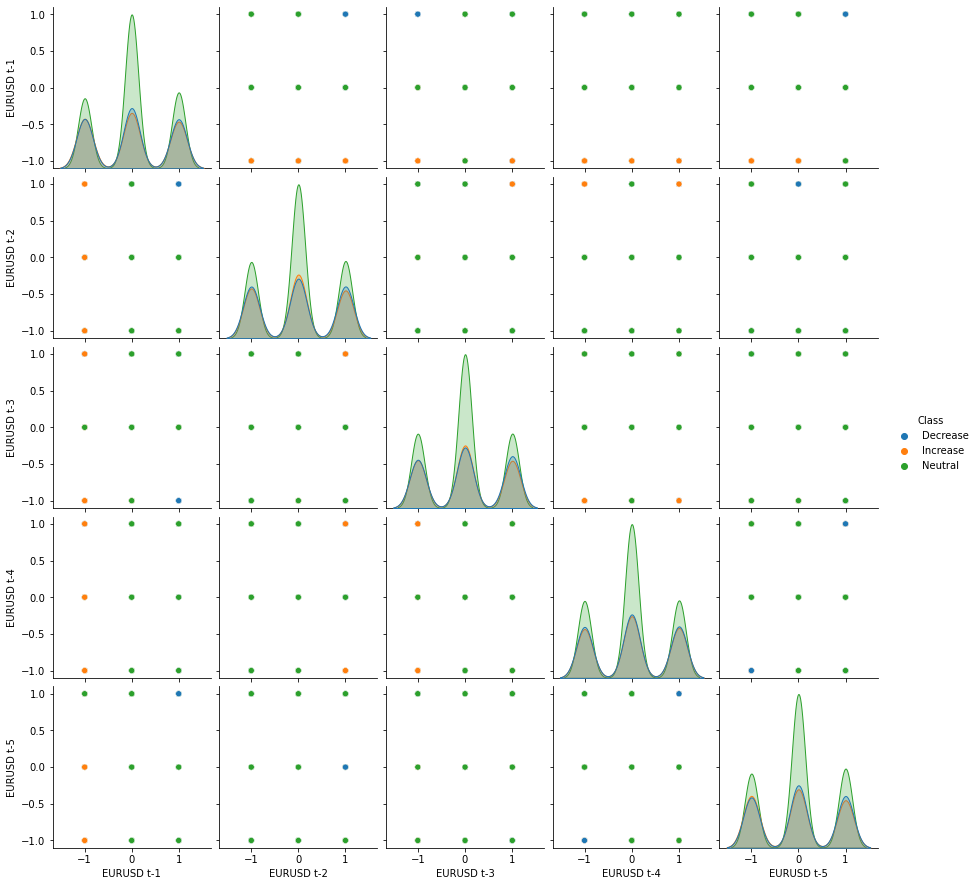

In [30]:
# Try with the signal
plt.clf()
sns.pairplot(pd.concat([X_EURUSD_signal_train, Y_EURUSD_class_train], axis = 1), hue="Class")
plt.show()

From what we can see, it is very difficult to tell where the clusters are for the EURUSD lagged varibles and signals so we better find other ways to predict the outcome of the variables. The signals are much more relevant actually.

## IV. Implementing Machine Learning
This will be the most important part of our analysis, it is actually related to the models we are going to use for the analysis and we can filter some models already.

### a. Linear Regression

In [31]:
# Calling the model
linear_model = LinearRegression()
# Fitting the model with the training set
model_lin_1 = linear_model.fit(X_EURUSD_returns_train, Y_EURUSD_returns_train)
# Evaluate with the training set 
print("Prediction score for the training set : ", model_lin_1.score(X_EURUSD_returns_train, Y_EURUSD_returns_train))

Prediction score for the training set :  0.0011024665290382263


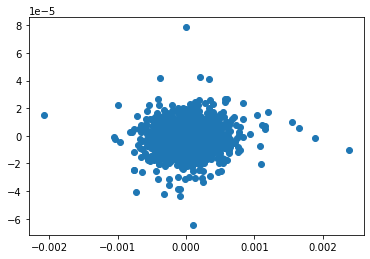

In [32]:
# Show whether we have a line (Y = Y_pred ?)
Y_EURUSD_returns_predicted_1 = model_lin_1.predict(X_EURUSD_returns_test)
plt.clf()
plt.scatter(Y_EURUSD_returns_test, Y_EURUSD_returns_predicted_1)
plt.show()

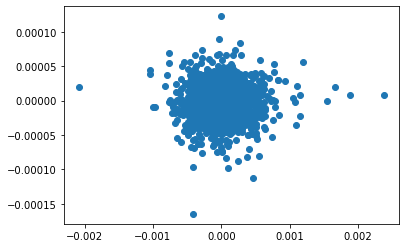

In [33]:
# Try with the world return
model_lin_2 = linear_model.fit(X_WORLD_returns_train, Y_EURUSD_returns_train)
Y_EURUSD_returns_predicted_2 = model_lin_2.predict(X_WORLD_returns_test)
plt.clf()
plt.scatter(Y_EURUSD_returns_test, Y_EURUSD_returns_predicted_2)
plt.show()
# Seems better but still not relevant

In both cases, we can notice that the appearance ofthe curve is not a line so we do not have a lot of data that match Y = Y_pred and so we can tell from these graphes that the linear models are not relevant for the trading analysis.

### b. Logistic Regression
Another model that is use some times for classification problem is the logistic regression that is basically counting on "How probable Y can be equal to a certain outcome ?", it works with probabilities)

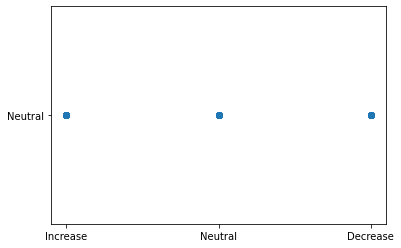

In [34]:
# Calling the model
logistic_model = LogisticRegression()
# Try with signals of EURUSD and predict the classes
model_log_1 = logistic_model.fit(X_EURUSD_signal_train, Y_EURUSD_class_train)
Y_EURUSD_class_predicted_1 = pd.Series(model_log_1.predict(X_EURUSD_signal_test))
plt.clf()
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_class_predicted_1)
plt.show()

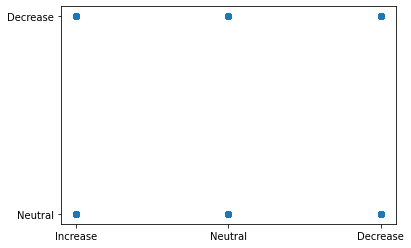

In [35]:
# Try with positive signals
model_log_2 = logistic_model.fit(X_EURUSD_pos_sign_train, Y_EURUSD_class_train)
Y_EURUSD_class_predicted_2 = model_log_2.predict(X_EURUSD_pos_sign_test)
plt.clf()
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_class_predicted_2)
plt.show()

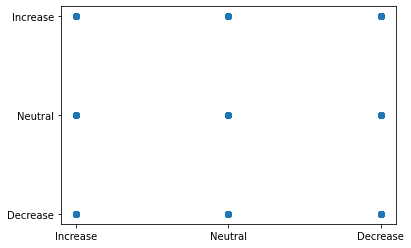

In [36]:
# Try with quantitive instead but still is not working so let's keep up with the signals
model_log_3 = logistic_model.fit(X_WORLD_pos_sign_train, Y_EURUSD_class_train)
Y_EURUSD_class_predicted_3 = model_log_3.predict(X_WORLD_pos_sign_test)
plt.clf()
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_class_predicted_3)
plt.show()


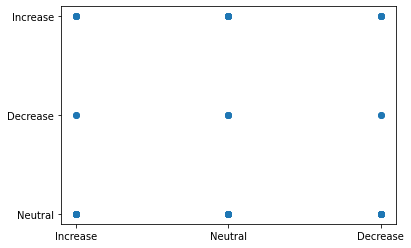

In [37]:
# Try with world data
model_log_4 = logistic_model.fit(X_WORLD_signal_train, Y_EURUSD_class_train)
Y_EURUSD_class_predicted_4 = model_log_4.predict(X_WORLD_signal_test)
plt.clf()
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_class_predicted_4)
plt.show()


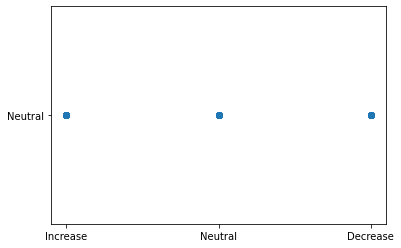

In [38]:
# This one does not seem very relevant but we will redo a back test later
model_log_5 = logistic_model.fit(X_t_1_forex_train, Y_EURUSD_class_train)
Y_EURUSD_class_predicted_5 = model_log_5.predict(X_t_1_forex_test)
plt.clf()
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_class_predicted_5)
plt.show()

From what we can observe in the graphs, we can tell that the 2nd, 3rd and 4th model can predict the three different outcomes while the 1st and second fail to predict other outcomes than Neutral, so we can keep going with the 2nd, 3rd and 4th logistic regression model: WORLD signals, World postive signals and also EURUSD positive signals

### c. Lasso and Ridge

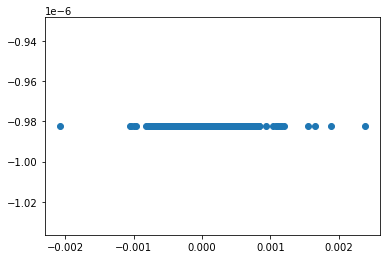

In [39]:
# Creating the lasso model with the returns
lasso_model = Lasso(fit_intercept=True, alpha=0.5)
lasso_1 = lasso_model.fit(X_EURUSD_returns_train, Y_EURUSD_returns_train)
Y_EURUSD_lasso_predicted_1 = lasso_1.predict(X_EURUSD_returns_test)
plt.clf()
plt.scatter(Y_EURUSD_returns_test, Y_EURUSD_lasso_predicted_1)
plt.show()


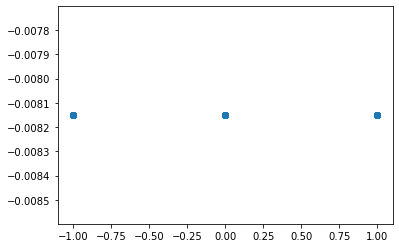

In [40]:
# With the signals
lasso_2 = lasso_model.fit(X_EURUSD_signal_train, Y_EURUSD_q_class_train)
Y_EURUSD_lasso_predicted_2 = lasso_2.predict(X_EURUSD_signal_test)
plt.clf()
plt.scatter(Y_EURUSD_q_class_test, Y_EURUSD_lasso_predicted_2)
plt.show()

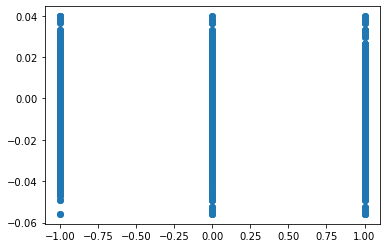

In [41]:
# Creating the ridge model
ridge_model = Ridge()
ridge_1 = ridge_model.fit(X_EURUSD_signal_train, Y_EURUSD_q_class_train)
Y_EURUSD_ridge_predicted_1 = ridge_1.predict(X_EURUSD_signal_test)
plt.clf()
plt.scatter(Y_EURUSD_q_class_test, Y_EURUSD_ridge_predicted_1)
plt.show()


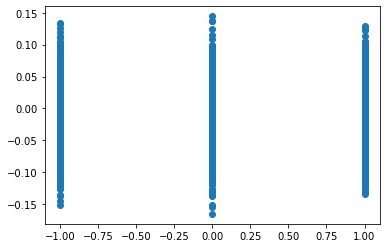

In [42]:
# Try with world data
ridge_2 = ridge_model.fit(X_WORLD_signal_train, Y_EURUSD_q_class_train)
Y_EURUSD_ridge_predicted_2 = ridge_2.predict(X_WORLD_signal_test)
plt.clf()
plt.scatter(Y_EURUSD_q_class_test, Y_EURUSD_ridge_predicted_2)
plt.show()

In this case, we can see that we fail to predict any relevant outcome with Lasso and Ridge models, so they will not futher be used for the analysis because the predictions are very poor and they are only predicting Neutral outcomes.
### d. Linear Discriminant Analysis (LDA) and Random Forests
Linear discriminant analysis as PCA is use to standardize and simplify a problem, and random forest tends to optimize the problem and the outcome therefore we can probably use these as our model.

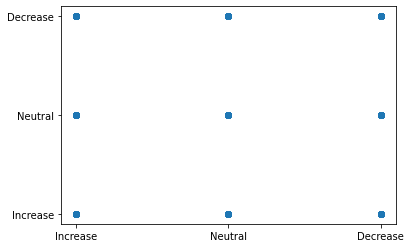

In [43]:
# Scalling the features
std_scal = StandardScaler()
# Use returns
X_train_std_scal_1 = std_scal.fit_transform(X_EURUSD_returns_train)
X_std_test_scal_1 = std_scal.transform(X_EURUSD_returns_test)
# Creating a 1 component LDA
lda = LDA(n_components=1)
# Transforming the variables
X_train_lda_1 = lda.fit_transform(X_train_std_scal_1, Y_EURUSD_class_train)
X_test_lda_1 = lda.transform(X_std_test_scal_1)
forest = RandomForestClassifier(max_depth=2, random_state=0)
rand_for_1 = forest.fit(X_train_lda_1, Y_EURUSD_class_train)
Y_EURUSD_for_predicted_1 = rand_for_1.predict(X_test_lda_1)
plt.clf() 
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_for_predicted_1)
plt.show()


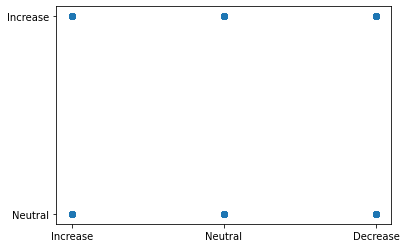

In [44]:
# Try with world data and returns
X_train_std_scal_2 = std_scal.fit_transform(X_WORLD_returns_train)
X_std_test_scal_2 = std_scal.transform(X_WORLD_returns_test)
lda = LDA(n_components=1)
X_train_lda_2 = lda.fit_transform(X_train_std_scal_2, Y_EURUSD_class_train)
X_test_lda_2 = lda.transform(X_std_test_scal_2)
rand_for_2 = forest.fit(X_train_lda_2, Y_EURUSD_class_train)
Y_EURUSD_for_predicted_2 = rand_for_2.predict(X_test_lda_2)
plt.clf() 
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_for_predicted_2)
plt.show()


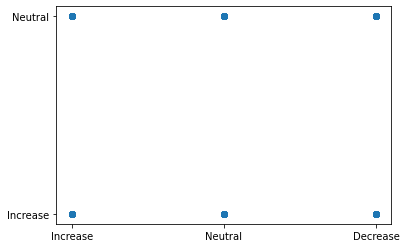

In [45]:
# Let's try with the signals
X_train_std_scal_3 = std_scal.fit_transform(X_EURUSD_signal_train)
X_std_test_scal_3 = std_scal.transform(X_EURUSD_signal_test)
lda = LDA(n_components=1)
X_train_lda_3 = lda.fit_transform(X_train_std_scal_3, Y_EURUSD_class_train)
X_test_lda_3 = lda.transform(X_std_test_scal_3)
rand_for_3 = forest.fit(X_train_lda_3, Y_EURUSD_class_train)
Y_EURUSD_for_predicted_3 = rand_for_3.predict(X_test_lda_3)
plt.clf() 
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_for_predicted_3)
plt.show()


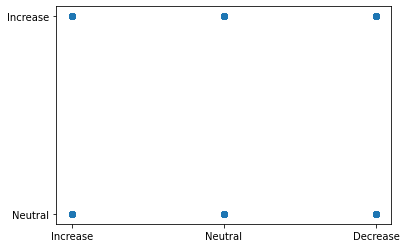

In [46]:
# Use World data for the signal
X_train_std_scal_4 = std_scal.fit_transform(X_WORLD_signal_train)
X_std_test_scal_4 = std_scal.transform(X_WORLD_signal_test)
# 1 component LDA
lda = LDA(n_components=1)
X_train_lda_4 = lda.fit_transform(X_train_std_scal_4, Y_EURUSD_class_train)
X_test_lda_4 = lda.transform(X_std_test_scal_4)
rand_for_4 = forest.fit(X_train_lda_4, Y_EURUSD_class_train)
Y_EURUSD_for_predicted_4 = rand_for_4.predict(X_test_lda_4)
plt.clf() 
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_for_predicted_4)
plt.show()


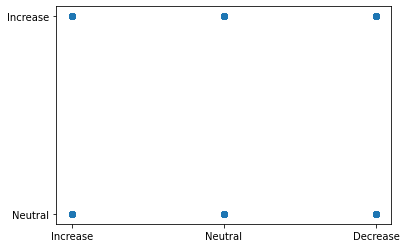

In [47]:
# May be there is an overfit, let's try with data at t-1
X_train_std_scal_5 = std_scal.fit_transform(X_t_1_forex_train)
X_std_test_scal_5 = std_scal.transform(X_t_1_forex_test)
lda = LDA(n_components=1)
X_train_lda_5 = lda.fit_transform(X_train_std_scal_5, Y_EURUSD_class_train)
X_test_lda_5 = lda.transform(X_std_test_scal_5)
rand_for_5 = forest.fit(X_train_lda_5, Y_EURUSD_class_train)
Y_EURUSD_for_predicted_5 = rand_for_5.predict(X_test_lda_5)
plt.clf() 
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_for_predicted_5)
plt.show()

From what we can see, we can tell that the first and the last models are failing to predict some outcomes, the last model fails to predict increases at 100% so we will not consider the model. We can consider Model 2, 3, and 4 about the world return, the EURUSD signals and the world signals.

### c. Regression Trees
Regression trees can be useful to predict an outcome and to see which variables helps in decision but they are not always very accurate so we will see. It uses quantitative classes, so we will have to use quatitative classes.

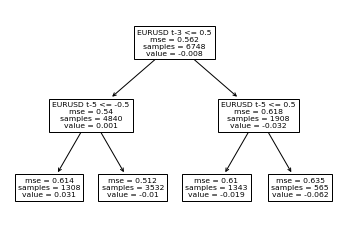

In [48]:
# Creating a tree with depth 2 and depth 5
model_tree_1 = DecisionTreeRegressor(max_depth=2)
model_tree_2 = DecisionTreeRegressor(max_depth=5)
model_tree_1.fit(X_EURUSD_signal_train,Y_EURUSD_q_class_train)
plt.clf()
tree.plot_tree(model_tree_1, feature_names = X_EURUSD_signal_train.columns)
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

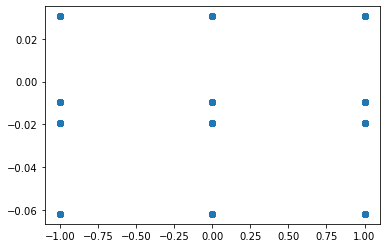

In [49]:
# We can see that even though we round up the model, the predictions will mostly be Neutral
model_tree_2.fit(X_EURUSD_signal_train,Y_EURUSD_q_class_train)
# Prediction with depth 2
Y_EURUSD_tree_predicted_1 = model_tree_1.predict(X_EURUSD_signal_test)
Y_EURUSD_tree_predicted_2 = model_tree_2.predict(X_EURUSD_signal_test)
plt.clf() 
plt.scatter(Y_EURUSD_q_class_test, Y_EURUSD_tree_predicted_1)
plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

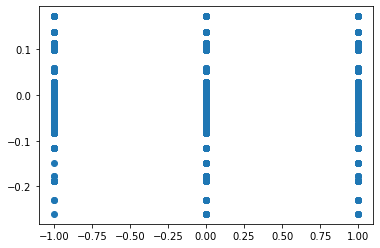

In [50]:
# Depth 5
plt.clf() 
plt.scatter(Y_EURUSD_q_class_test, Y_EURUSD_tree_predicted_2)
plt.show

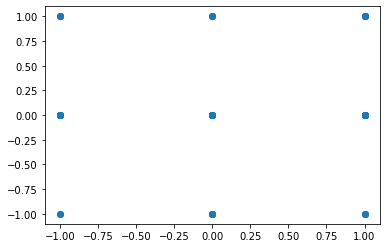

In [51]:
# Try with the other variables, the tree does not seem to be very accurate for signals, try with returns
model_tree_3 = DecisionTreeRegressor(max_depth=2)
model_tree_4 = DecisionTreeRegressor(max_depth=5)
model_tree_3.fit(X_EURUSD_returns_train,Y_EURUSD_q_class_train)
Y_EURUSD_tree_predicted_3 = model_tree_3.predict(X_EURUSD_returns_test)
Y_EURUSD_tree_predicted_3 = np.around(Y_EURUSD_tree_predicted_3,0)
plt.clf() 
plt.scatter(Y_EURUSD_q_class_test, Y_EURUSD_tree_predicted_3)
plt.show()


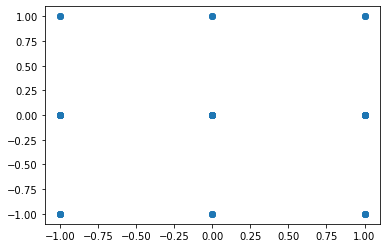

In [52]:
# Not accurate, may be need to have a deeper tree ? 
model_tree_4.fit(X_EURUSD_returns_train,Y_EURUSD_q_class_train)
Y_EURUSD_tree_predicted_4 = model_tree_4.predict(X_EURUSD_returns_test)
Y_EURUSD_tree_predicted_4 = np.around(Y_EURUSD_tree_predicted_4,0)
plt.clf() 
plt.scatter(Y_EURUSD_q_class_test, Y_EURUSD_tree_predicted_4)
plt.show()


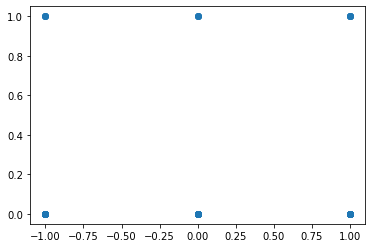

In [53]:
# Seems better in term of scale. May be let us try with world data ?
model_tree_5 = DecisionTreeRegressor(max_depth=2)
model_tree_6 = DecisionTreeRegressor(max_depth=5)
model_tree_5.fit(X_WORLD_returns_train,Y_EURUSD_q_class_train)
Y_EURUSD_tree_predicted_5 = model_tree_5.predict(X_WORLD_returns_test)
Y_EURUSD_tree_predicted_5 = np.around(Y_EURUSD_tree_predicted_5,0)
plt.clf() 
plt.scatter(Y_EURUSD_q_class_test, Y_EURUSD_tree_predicted_5)
plt.show()
# It fails to predict the neutral state

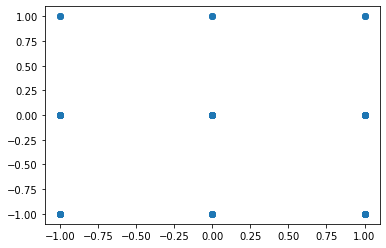

In [54]:
# Let's try with world returns
model_tree_6.fit(X_WORLD_returns_train,Y_EURUSD_q_class_train)
Y_EURUSD_tree_predicted_6 = model_tree_6.predict(X_WORLD_returns_test)
Y_EURUSD_tree_predicted_6 = np.around(Y_EURUSD_tree_predicted_6,0)
plt.clf() 
plt.scatter(Y_EURUSD_q_class_test, Y_EURUSD_tree_predicted_6)
plt.show()


From what we can see in the code, we can tell that the regression trees are not good models, the only relevant one might be the last model, the others are failing to predict some state or are completely irrelevant. So we can use world returns

### d. Support Vector Machines Model (SVM)

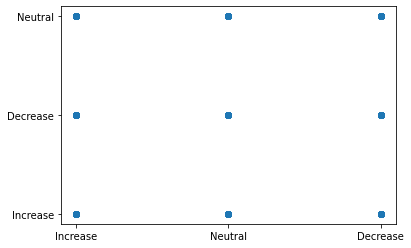

In [55]:
# Try with the returns first
svm_model = svm.SVC()
model_svm_1 = svm_model.fit(X_EURUSD_returns_train, Y_EURUSD_class_train)
Y_EURUSD_svm_predicted_1 = model_svm_1.predict(X_EURUSD_returns_test)
plt.clf() 
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_svm_predicted_1)
plt.show()


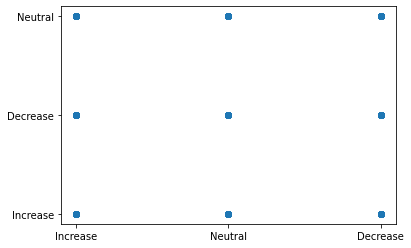

In [56]:
# The 3 classes are predicted but may be themodel can be improved 
model_svm_2 = svm_model.fit(X_EURUSD_signal_train, Y_EURUSD_class_train)
Y_EURUSD_svm_predicted_2 = model_svm_2.predict(X_EURUSD_signal_test)
plt.clf() 
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_svm_predicted_2)
plt.show()


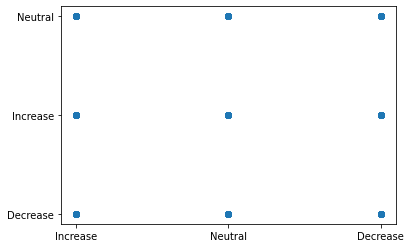

In [57]:
# Maybe with the world data ? 
model_svm_3 = svm_model.fit(X_WORLD_returns_train, Y_EURUSD_class_train)
Y_EURUSD_svm_predicted_3 = model_svm_3.predict(X_WORLD_returns_test)
plt.clf() 
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_svm_predicted_3)
plt.show()


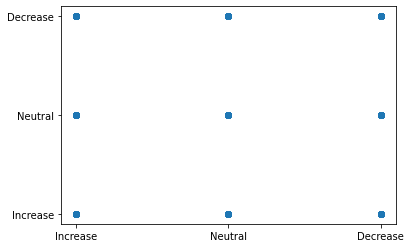

In [58]:
# With the signals
model_svm_4 = svm_model.fit(X_WORLD_signal_train, Y_EURUSD_class_train)
Y_EURUSD_svm_predicted_4 = model_svm_4.predict(X_WORLD_signal_test)
plt.clf() 
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_svm_predicted_4)
plt.show()

SVM models seems to predict all the different states of the market so we can use SVM models for our analysis. This can be relevant later but let's assess the models later.

### e. Gradient boosting regressor

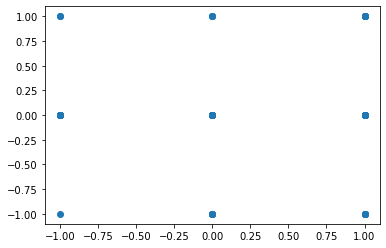

In [59]:
# Gradient boosting regressor can be useful
grad_boost_reg_model = GradientBoostingRegressor(random_state = 0)
# Fitting the model
model_grad_1 = grad_boost_reg_model.fit(X_EURUSD_returns_train, Y_EURUSD_q_class_train)
Y_EURUSD_grad_1 = model_grad_1.predict(X_EURUSD_returns_test)
plt.clf() 
plt.scatter(Y_EURUSD_q_class_test, np.around(Y_EURUSD_grad_1))
plt.show()


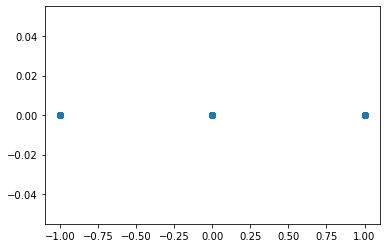

In [60]:
# The model can be improved so let's try with the signals
model_grad_2 = grad_boost_reg_model.fit(X_EURUSD_signal_train, Y_EURUSD_q_class_train)
Y_EURUSD_grad_2 = model_grad_2.predict(X_EURUSD_signal_test)
plt.clf() 
plt.scatter(Y_EURUSD_q_class_test, np.around(Y_EURUSD_grad_2))
plt.show()


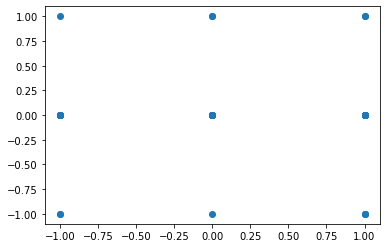

In [61]:
# This one is even worse, may be with the world data
model_grad_3 = grad_boost_reg_model.fit(X_WORLD_returns_train, Y_EURUSD_q_class_train)
Y_EURUSD_grad_3 = model_grad_3.predict(X_WORLD_returns_test)
plt.clf() 
plt.scatter(Y_EURUSD_q_class_test, np.around(Y_EURUSD_grad_3))
plt.show()

Gradient boosting model can involve less errors compared to the others so the model may be relevant at some point.

### f. K-Nearest Neighbor

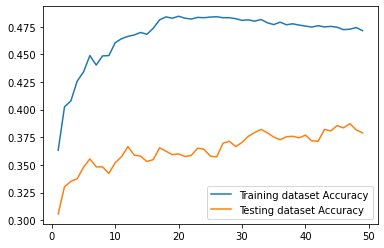

Optimal neighbors :  33 Accuracy :  0.43178225647105317


In [62]:
# Evaluate how accurate the prediction is
train_accuracy = np.empty(50)
test_accuracy = np.empty(50)
neigh = 0
accuracy = 0
# Testing with several neighbors
for i, k in enumerate(np.arange(1, 50)):
    knn = KNeighborsClassifier(n_neighbors=k+1)
    knn.fit(X_EURUSD_signal_train, Y_EURUSD_class_train) 
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_EURUSD_signal_train, Y_EURUSD_class_train)
    test_accuracy[i] = knn.score(X_EURUSD_signal_test, Y_EURUSD_class_test)
    if (train_accuracy[i]+test_accuracy[i])/2 > accuracy:
        accuracy = (train_accuracy[i]+test_accuracy[i])/2
        neigh = i+1
neighbors = np.arange(1, 50)
# Assess the number of optimal neighbors
plt.clf()
plt.plot(neighbors, train_accuracy[:-1], label = 'Training dataset Accuracy')
plt.plot(neighbors, test_accuracy[:-1], label = 'Testing dataset Accuracy')
plt.legend()
plt.show()
print("Optimal neighbors : ", neigh, "Accuracy : ", accuracy)

30 - 49 neighbors seems to be the one that give the optimal number of neighbors even though this number can change depending on the test. We can actually store the number in a variable to make it more accurate.

In [63]:
# Use optimal neighbors
knn_eff = KNeighborsClassifier(n_neighbors=neigh)
knn_1 = knn_eff.fit(X_EURUSD_signal_train, Y_EURUSD_class_train)
Y_EURUSD_knn_1 = knn_1.predict(X_EURUSD_signal_test)
# For the following, we will assume that optimal k is efficient even though to analyze the data
knn_2 = knn_eff.fit(X_WORLD_signal_train, Y_EURUSD_class_train)
Y_EURUSD_knn_2 = knn_2.predict(X_WORLD_signal_test)
# Let's try with the returns
knn_3 = knn_eff.fit(X_EURUSD_returns_train, Y_EURUSD_class_train)
Y_EURUSD_knn_3 = knn_3.predict(X_EURUSD_returns_test)
# World return
knn_4 = knn_eff.fit(X_WORLD_returns_train, Y_EURUSD_class_train)
Y_EURUSD_knn_4 = knn_4.predict(X_WORLD_returns_test)

### g. Nearest Centroid

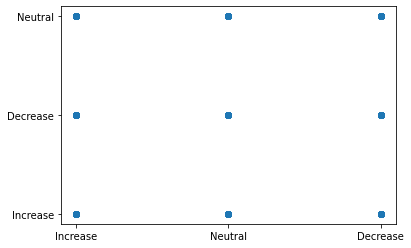

In [64]:
# First centroid
centroid_model = NearestCentroid()
model_centro_1 = centroid_model.fit(X_EURUSD_returns_train, Y_EURUSD_class_train)
Y_EURUSD_centro_1 = model_centro_1.predict(X_EURUSD_returns_test)
plt.clf() 
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_centro_1)
plt.show()


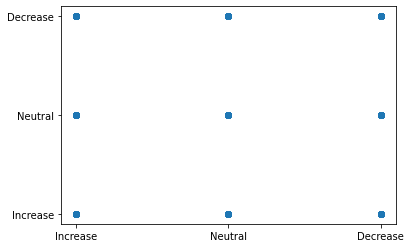

In [65]:
# Would have to test it later
model_centro_2 = centroid_model.fit(X_EURUSD_signal_train, Y_EURUSD_class_train)
Y_EURUSD_centro_2 = model_centro_2.predict(X_EURUSD_signal_test)
plt.clf() 
plt.scatter(Y_EURUSD_class_test, Y_EURUSD_centro_2)
plt.show()


In [66]:
model_centro_3 = centroid_model.fit(X_WORLD_signal_train, Y_EURUSD_class_train)
Y_EURUSD_centro_3 = model_centro_3.predict(X_WORLD_signal_test) 
# Let's ignore the plots because they are actually not relevant
model_centro_4 = centroid_model.fit(X_WORLD_returns_train, Y_EURUSD_class_train)
Y_EURUSD_centro_4 = model_centro_4.predict(X_WORLD_returns_test) 

## V. Assessment of the fits
After creating the model, we are using the metrics to assess the goodness of the fits.

In [67]:
# Creating the classes 
classes = Y_EURUSD_class_test.unique()
# Linear regression : Y_EURUSD_returns_predicted_1, Y_EURUSD_returns_predicted_2
    # First prediction :
print("MSE model 1 :", mean_squared_error(Y_EURUSD_returns_test, Y_EURUSD_returns_predicted_1))
print("R2 model 1 :", r2_score(Y_EURUSD_returns_test, Y_EURUSD_returns_predicted_1))

    # Second prediction :
print("MSE model 2 :", mean_squared_error(Y_EURUSD_returns_test, Y_EURUSD_returns_predicted_2))
print("R2 model 2 :", r2_score(Y_EURUSD_returns_test, Y_EURUSD_returns_predicted_2))

MSE model 1 : 5.918776550378747e-08
R2 model 1 : 0.0007792114886927548
MSE model 2 : 5.979209150811129e-08
R2 model 2 : -0.0094231521487671


From what we can observe, the linear models are not good to predict the outcome and they are not good fits for our problem.

<Figure size 432x288 with 0 Axes>

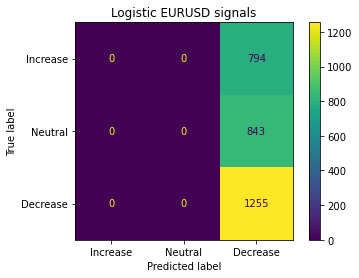

<Figure size 432x288 with 0 Axes>

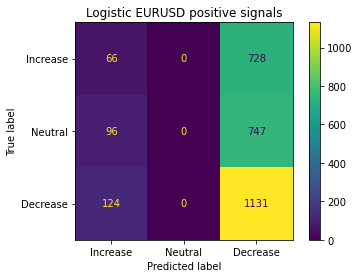

<Figure size 432x288 with 0 Axes>

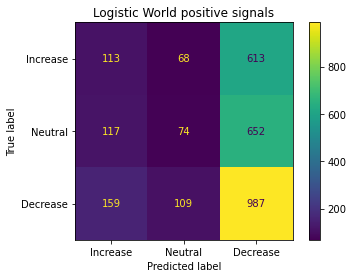

<Figure size 432x288 with 0 Axes>

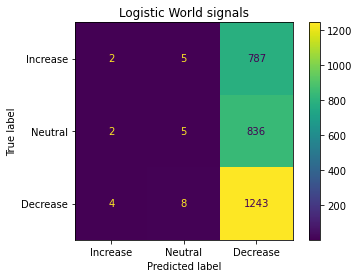

<Figure size 432x288 with 0 Axes>

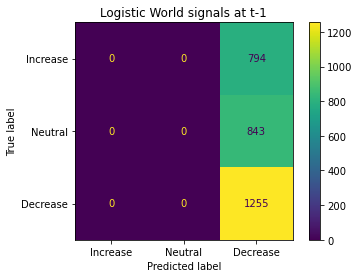

In [68]:
ax= plt.subplot()
    # Logistic Model 1 :
c_matr_1 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_class_predicted_1)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_1,display_labels=classes).plot()
d.ax_.set_title("Logistic EURUSD signals")
plt.show()
    # Model 2 :
c_matr_2 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_class_predicted_2)
c_matr_2
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_2,display_labels=classes).plot()
d.ax_.set_title("Logistic EURUSD positive signals")
plt.show()
    # Model 3 :
c_matr_3 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_class_predicted_3)
c_matr_3
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_3,display_labels=classes).plot()
d.ax_.set_title("Logistic World positive signals")
plt.show()
    # Model 4 :
c_matr_4 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_class_predicted_4)
c_matr_4
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_4,display_labels=classes).plot()
d.ax_.set_title("Logistic World signals")
plt.show()
    # Model 5 :
c_matr_5 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_class_predicted_5)
c_matr_5
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_5,display_labels=classes).plot()
d.ax_.set_title("Logistic World signals at t-1")
plt.show()

MSE model lasso 1 : 5.9295272343221704e-08
R2 model lasso 1 : -0.0010357424626092904
MSE model lasso 2 : 6.660262787462028e-05
R2 model lasso 2 : -1123.4001150464892


<Figure size 432x288 with 0 Axes>

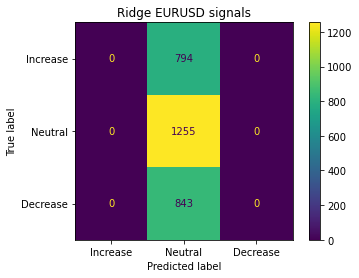

<Figure size 432x288 with 0 Axes>

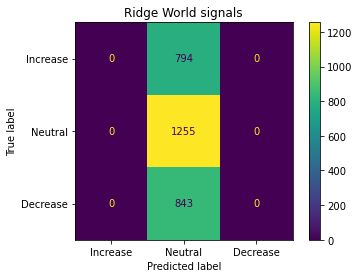

In [69]:
print("MSE model lasso 1 :", mean_squared_error(Y_EURUSD_returns_test, Y_EURUSD_lasso_predicted_1))
print("R2 model lasso 1 :", r2_score(Y_EURUSD_returns_test, Y_EURUSD_lasso_predicted_1))
    # Lasso 2
print("MSE model lasso 2 :", mean_squared_error(Y_EURUSD_returns_test, Y_EURUSD_lasso_predicted_2))
print("R2 model lasso 2 :", r2_score(Y_EURUSD_returns_test, Y_EURUSD_lasso_predicted_2))
# Lasso model does not seem to be accurate
    # Ridge 1
c_matr_6 = confusion_matrix(Y_EURUSD_q_class_test, np.around(Y_EURUSD_ridge_predicted_1))
c_matr_6
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_6,display_labels=classes).plot()
d.ax_.set_title("Ridge EURUSD signals")
plt.show()
   # Ridge 2
c_matr_7 = confusion_matrix(Y_EURUSD_q_class_test, np.around(Y_EURUSD_ridge_predicted_2))
c_matr_7
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_7,display_labels=classes).plot()
d.ax_.set_title("Ridge World signals")
plt.show()

<Figure size 432x288 with 0 Axes>

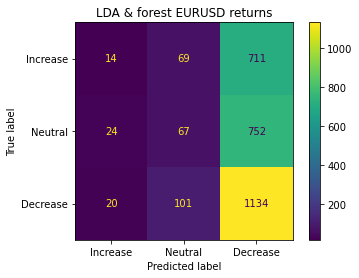

<Figure size 432x288 with 0 Axes>

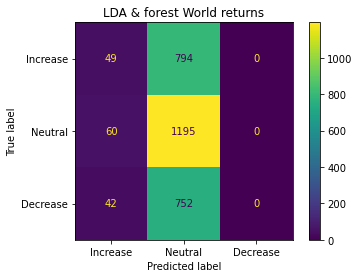

<Figure size 432x288 with 0 Axes>

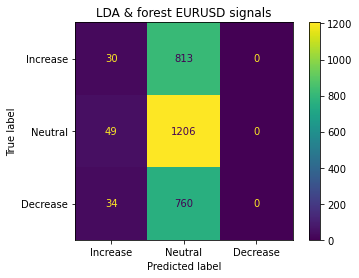

<Figure size 432x288 with 0 Axes>

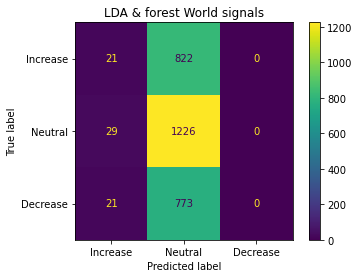

<Figure size 432x288 with 0 Axes>

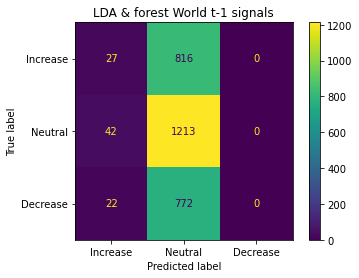

In [70]:
# LDA & forest : Y_EURUSD_for_predicted_1, Y_EURUSD_for_predicted_2, Y_EURUSD_for_predicted_3,
# Y_EURUSD_for_predicted_4, Y_EURUSD_for_predicted_5
c_matr_8 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_for_predicted_1)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_8,display_labels=classes).plot()
d.ax_.set_title("LDA & forest EURUSD returns")
plt.show()
# Seems better
c_matr_9 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_for_predicted_2, labels = classes)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_9,display_labels=classes).plot()
d.ax_.set_title("LDA & forest World returns")
plt.show()
c_matr_10 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_for_predicted_3, labels = classes)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_10,display_labels=classes).plot()
d.ax_.set_title("LDA & forest EURUSD signals")
plt.show()
c_matr_11 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_for_predicted_4, labels = classes)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_11,display_labels=classes).plot()
d.ax_.set_title("LDA & forest World signals")
plt.show()
c_matr_12 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_for_predicted_5, labels = classes)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_12,display_labels=classes).plot()
d.ax_.set_title("LDA & forest World t-1 signals")
plt.show()

<Figure size 432x288 with 0 Axes>

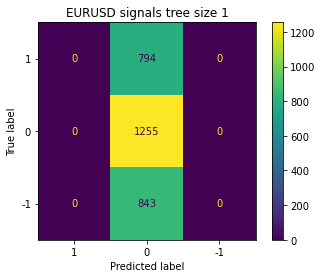

<Figure size 432x288 with 0 Axes>

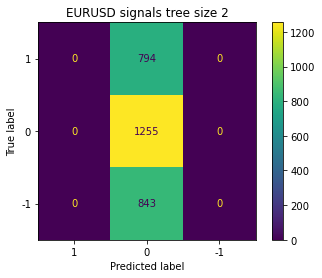

<Figure size 432x288 with 0 Axes>

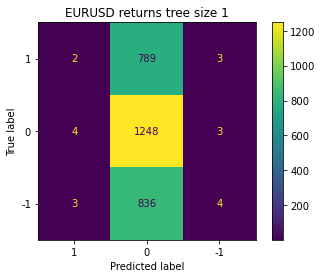

<Figure size 432x288 with 0 Axes>

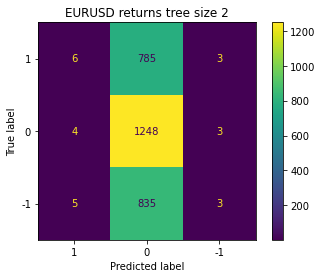

<Figure size 432x288 with 0 Axes>

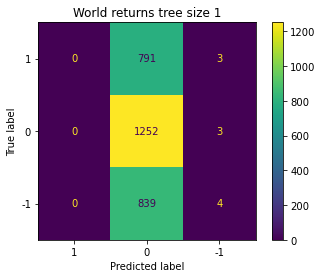

<Figure size 432x288 with 0 Axes>

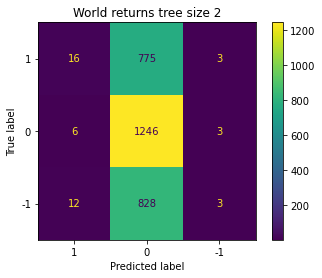

In [71]:
# Try with decison tree
q_classes = Y_EURUSD_q_class_test.unique()
c_matr_13 = confusion_matrix(Y_EURUSD_q_class_test, np.around(Y_EURUSD_tree_predicted_1))
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_13,display_labels=q_classes).plot()
d.ax_.set_title("EURUSD signals tree size 1")
plt.show()
c_matr_14 = confusion_matrix(Y_EURUSD_q_class_test, np.around(Y_EURUSD_tree_predicted_2))
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_14,display_labels=q_classes).plot()
d.ax_.set_title("EURUSD signals tree size 2")
plt.show()
c_matr_15 = confusion_matrix(Y_EURUSD_q_class_test, np.around(Y_EURUSD_tree_predicted_3))
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_15,display_labels=q_classes).plot()
d.ax_.set_title("EURUSD returns tree size 1")
plt.show()
c_matr_16 = confusion_matrix(Y_EURUSD_q_class_test, np.around(Y_EURUSD_tree_predicted_4))
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_16,display_labels=q_classes).plot()
d.ax_.set_title("EURUSD returns tree size 2")
plt.show()
c_matr_17 = confusion_matrix(Y_EURUSD_q_class_test, np.around(Y_EURUSD_tree_predicted_5))
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_17,display_labels=q_classes).plot()
d.ax_.set_title("World returns tree size 1")
plt.show()
c_matr_18 = confusion_matrix(Y_EURUSD_q_class_test, np.around(Y_EURUSD_tree_predicted_6))
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_18,display_labels=q_classes).plot()
d.ax_.set_title("World returns tree size 2")
plt.show()

<Figure size 432x288 with 0 Axes>

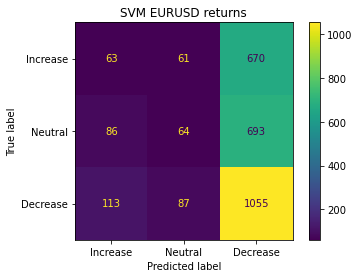

<Figure size 432x288 with 0 Axes>

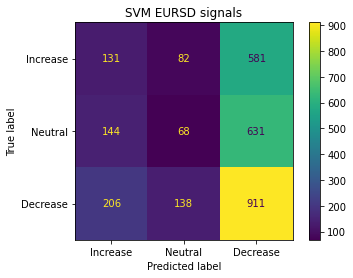

<Figure size 432x288 with 0 Axes>

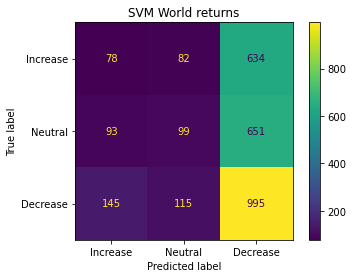

<Figure size 432x288 with 0 Axes>

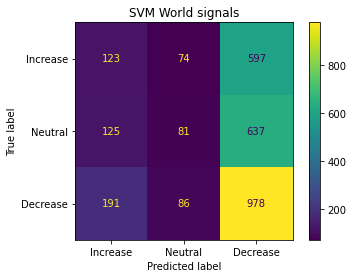

In [72]:
# SVM model
c_matr_19 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_svm_predicted_1)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_19,display_labels=classes).plot()
d.ax_.set_title("SVM EURUSD returns")
plt.show()
c_matr_20 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_svm_predicted_2)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_20,display_labels=classes).plot()
d.ax_.set_title("SVM EURSD signals")
plt.show()
c_matr_21 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_svm_predicted_3)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_21,display_labels=classes).plot()
d.ax_.set_title("SVM World returns")
plt.show()
c_matr_22 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_svm_predicted_4)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_22,display_labels=classes).plot()
d.ax_.set_title("SVM World signals")
plt.show()

<Figure size 432x288 with 0 Axes>

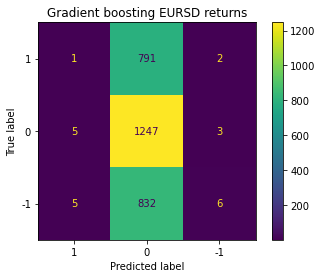

<Figure size 432x288 with 0 Axes>

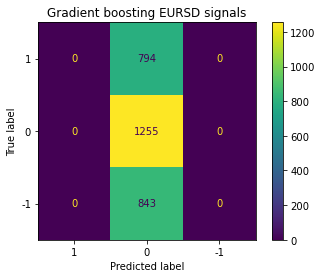

<Figure size 432x288 with 0 Axes>

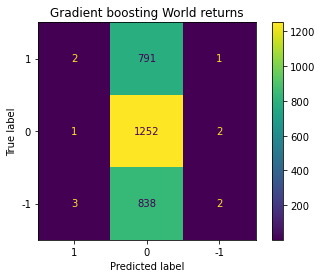

In [73]:
# Gradient boosting 
c_matr_23 = confusion_matrix(Y_EURUSD_q_class_test, np.around(Y_EURUSD_grad_1))
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_23,display_labels=q_classes).plot()
d.ax_.set_title("Gradient boosting EURSD returns")
plt.show()
c_matr_24 = confusion_matrix(Y_EURUSD_q_class_test, np.around(Y_EURUSD_grad_2))
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_24,display_labels=q_classes).plot()
d.ax_.set_title("Gradient boosting EURSD signals")
plt.show()
c_matr_25 = confusion_matrix(Y_EURUSD_q_class_test, np.around(Y_EURUSD_grad_3))
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_25,display_labels=q_classes).plot()
d.ax_.set_title("Gradient boosting World returns")
plt.show()

<Figure size 432x288 with 0 Axes>

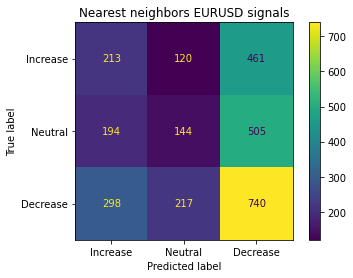

<Figure size 432x288 with 0 Axes>

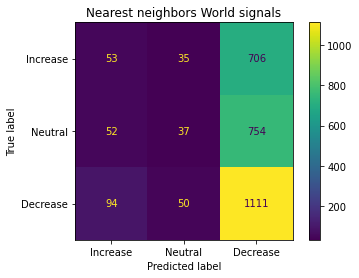

<Figure size 432x288 with 0 Axes>

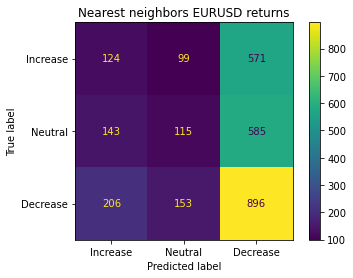

<Figure size 432x288 with 0 Axes>

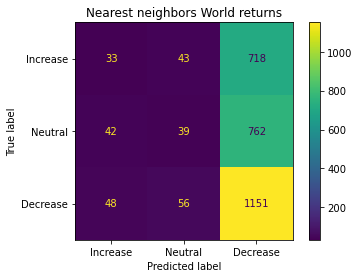

In [74]:
# Nearest neighbors : Y_EURUSD_knn_1 Y_EURUSD_knn_2, Y_EURUSD_knn_3, Y_EURUSD_knn_4
c_matr_26 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_knn_1)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_26,display_labels=classes).plot()
d.ax_.set_title("Nearest neighbors EURUSD signals")
plt.show()
c_matr_27 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_knn_2)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_27,display_labels=classes).plot()
d.ax_.set_title("Nearest neighbors World signals")
plt.show()
c_matr_28 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_knn_3)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_28,display_labels=classes).plot()
d.ax_.set_title("Nearest neighbors EURUSD returns")
plt.show()
c_matr_29 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_knn_4)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_29,display_labels=classes).plot()
d.ax_.set_title("Nearest neighbors World returns")
plt.show()

<Figure size 432x288 with 0 Axes>

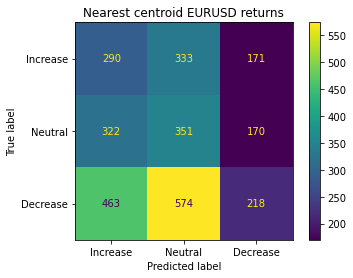

<Figure size 432x288 with 0 Axes>

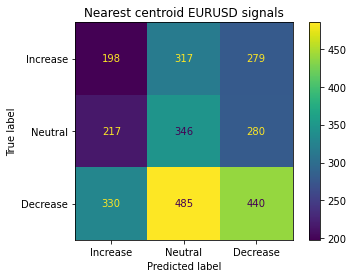

<Figure size 432x288 with 0 Axes>

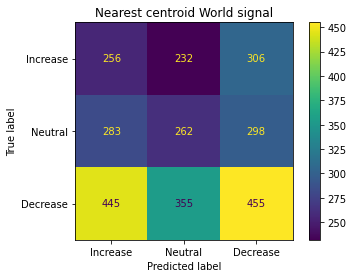

<Figure size 432x288 with 0 Axes>

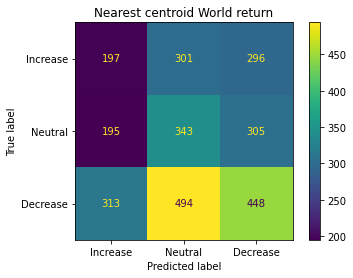

In [75]:
# Nearest centroid : Y_EURUSD_centro_1, Y_EURUSD_centro_2, Y_EURUSD_centro_3, Y_EURUSD_centro_4
c_matr_30 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_centro_1)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_30,display_labels=classes).plot()
d.ax_.set_title("Nearest centroid EURUSD returns")
plt.show()
c_matr_31 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_centro_2)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_31,display_labels=classes).plot()
d.ax_.set_title("Nearest centroid EURUSD signals")
plt.show()
c_matr_32 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_centro_3)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_32,display_labels=classes).plot()
d.ax_.set_title("Nearest centroid World signal")
plt.show()
c_matr_33 = confusion_matrix(Y_EURUSD_class_test, Y_EURUSD_centro_4)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_33,display_labels=classes).plot()
d.ax_.set_title("Nearest centroid World return")
plt.show()

From all the confusion matrices we can see, the most relevant ones are the ones from SVM, Nearest Centroid and Nearest Neighbor because the others fail to predict the actual result and lack accuracy and we can also use te postive signals from logistic regression. 

In [76]:
# Creating the data frame with the relevant predictions
data_predictions = pd.concat([pd.DataFrame(Y_EURUSD_class_predicted_2), pd.DataFrame(Y_EURUSD_class_predicted_3),
                              pd.DataFrame(Y_EURUSD_svm_predicted_1), pd.DataFrame(Y_EURUSD_svm_predicted_2), 
                              pd.DataFrame(Y_EURUSD_svm_predicted_3), pd.DataFrame(Y_EURUSD_svm_predicted_4),
                              pd.DataFrame(Y_EURUSD_knn_1), pd.DataFrame(Y_EURUSD_knn_2), 
                              pd.DataFrame(Y_EURUSD_knn_3), pd.DataFrame(Y_EURUSD_knn_4),
                              pd.DataFrame(Y_EURUSD_centro_1), pd.DataFrame(Y_EURUSD_centro_2), 
                              pd.DataFrame(Y_EURUSD_centro_3), pd.DataFrame(Y_EURUSD_centro_4)], axis = 1)
data_predictions.index = Y_EURUSD_class_test.index
data_predictions.columns = ['Logistic positve EURUSD', 'Logistic positve World', 'SVM EURUSD returns', 'SVM EURUSD Signal',
                            'SVM World returns', 'SVM World Signal', 'KNN EURUSD Signal', 'KNN World Signal',
                            'KNN EURUSD returns', 'KNN World returns', 'Centroid EURUSD returns', 'Centroid EURUSD Signal',
                            'Centroid World Signal', 'Centroid World returns']
data_predictions.head()

,Logistic positve EURUSD,Logistic positve World,SVM EURUSD returns,SVM EURUSD Signal,SVM World returns,SVM World Signal,KNN EURUSD Signal,KNN World Signal,KNN EURUSD returns,KNN World returns,Centroid EURUSD returns,Centroid EURUSD Signal,Centroid World Signal,Centroid World returns
time,,,,,,,,,,,,,,
2022-05-20 06:52:00,Neutral,Decrease,Increase,Increase,Decrease,Increase,Neutral,Neutral,Neutral,Decrease,Increase,Increase,Increase,Increase
2022-05-11 06:04:00,Neutral,Neutral,Decrease,Increase,Decrease,Neutral,Increase,Decrease,Decrease,Decrease,Increase,Increase,Increase,Increase
2022-05-13 17:38:00,Neutral,Neutral,Decrease,Decrease,Increase,Decrease,Decrease,Neutral,Neutral,Neutral,Decrease,Neutral,Decrease,Decrease
2022-05-10 09:38:00,Neutral,Decrease,Increase,Decrease,Increase,Neutral,Decrease,Neutral,Increase,Decrease,Decrease,Neutral,Increase,Increase
2022-05-11 04:10:00,Neutral,Decrease,Increase,Neutral,Increase,Increase,Neutral,Neutral,Increase,Neutral,Increase,Increase,Increase,Increase


In [77]:
# Compare to actual
pd.DataFrame(Y_EURUSD_class_test).head()

,Class
time,
2022-05-20 06:52:00,Increase
2022-05-11 06:04:00,Neutral
2022-05-13 17:38:00,Increase
2022-05-10 09:38:00,Increase
2022-05-11 04:10:00,Decrease


In [78]:
# Let's say that we want to have a dataframe with 3 different outcome (Inc, Dec, Neu), the most accurate non neutral prediction
data_evaluate_true_false = pd.DataFrame(None)
data_evaluate_true_false['Real'] = Y_EURUSD_class_test
for i in range(len(data_predictions.columns)) :
    for j in range(len(data_predictions)):
        data_evaluate_true_false.loc[data_predictions.index[j], 
                                     data_predictions.columns[i]] = (data_predictions.iloc[j,i] == Y_EURUSD_class_test.iloc[j] 
                                                                     and not(data_predictions.iloc[j,i] == 'Neutral') 
                                                                     and len(pd.unique(data_predictions.iloc[:,i]))== 3)
# Dataset with true of false
data_evaluate_true_false.head()

,Real,Logistic positve EURUSD,Logistic positve World,SVM EURUSD returns,SVM EURUSD Signal,SVM World returns,SVM World Signal,KNN EURUSD Signal,KNN World Signal,KNN EURUSD returns,KNN World returns,Centroid EURUSD returns,Centroid EURUSD Signal,Centroid World Signal,Centroid World returns
time,,,,,,,,,,,,,,,
2022-05-20 06:52:00,Increase,False,False,True,True,False,True,False,False,False,False,True,True,True,True
2022-05-11 06:04:00,Neutral,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2022-05-13 17:38:00,Increase,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2022-05-10 09:38:00,Increase,False,False,True,False,True,False,False,False,True,False,False,False,True,True
2022-05-11 04:10:00,Decrease,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [79]:
# Count the number of true per column and choose the best model accordingly
# Number of True
maximum_True = 0
# Column
index_max = 0
for i in range(len(data_predictions.columns)-1):
    nb_True = 0
    for j in range(len(data_predictions)):
        if(data_evaluate_true_false.iloc[j,i+1]):
            nb_True = nb_True + 1
    if maximum_True < nb_True:
        maximum_True = nb_True
        index_max = i+1
print("Maximum good prediction : ", maximum_True, " for method ", index_max+1, " : ", data_predictions.columns[index_max])

Maximum good prediction :  641  for method  12  :  Centroid EURUSD Signal


## VI. Back testing 
This step is very important in order to tell whether the strategy could work and test it with past data, the reason is if it doesn't work with past data, it can be complicated with real time data.

In [80]:
# Creating a frame with the closing price and the spread
frame_price['time'] = pd.to_datetime(frame_price['time'], unit='s')   
frame_price.index=pd.to_datetime(frame_price['time'])
frame_price = frame_price[['close','spread']]

# Selecting th prediction
y_predicted = data_predictions.iloc[:, index_max]
data_y = pd.concat([pd.DataFrame(Y_EURUSD_class_test), y_predicted], axis =1)
# Ask
frame_price.columns=['ask_price', 'spread']
# Creating the bid
frame_price['bid_price']=frame_price['ask_price'] - frame_price['spread']*point_trade
bt_frame=  pd.merge(frame_price, data_y, left_index=True, right_index=True, how=("right"))
bt_frame.head()
bt_frame['l_ask_price']=bt_frame['ask_price'].shift()
bt_frame['l_bid_price']=bt_frame['bid_price'].shift()
# Waiting
open_sell_position=False 
open_buy_position=False 
# Initial gain 
bt_frame['gain']=0.00000
bt_frame.dropna(inplace = True)
nb_trade = 0
# In all the dataframe (code from the class)
for i in range(0,len(bt_frame)):
    if (bt_frame[data_predictions.columns[index_max]][i]=="Decrease") and not open_sell_position  and not open_buy_position :
        nb_trade=nb_trade+1
        sell_price=bt_frame['l_bid_price'][i]
        tp_sell=bt_frame['l_bid_price'][i]-threshold*point_trade
        sl_sell=bt_frame['l_bid_price'][i]+threshold*point_trade
        open_sell_position=True
    if (bt_frame[data_predictions.columns[index_max]][i]=="Increase") and not open_sell_position and not open_buy_position :
        nb_trade=nb_trade+1
        buy_price=bt_frame['l_ask_price'][i]
        tp_buy=bt_frame['l_ask_price'][i]+threshold*point_trade
        sl_buy=bt_frame['l_ask_price'][i]-threshold*point_trade
        open_buy_position=True
    
    # In case we detected a decrease or an increase
    if open_sell_position:
        offer = sell_price
        if bt_frame['ask_price'][i] <= tp_sell:
            demand = tp_sell
        elif bt_frame['ask_price'][i] >= sl_sell:
            demand = sl_sell         
    if open_buy_position:
        demand = buy_price
        if bt_frame['bid_price'][i] <= sl_buy:
            offer = sl_buy
        elif bt_frame['bid_price'][i] >= tp_buy:
            offer = tp_buy
    if (open_buy_position and not open_sell_position) or (not open_buy_position and open_sell_position):
        # Calculate the gain
        bt_frame['gain'][i] = calculate_gain(offer, demand, standard_lot_value, lot_quantity)
        open_buy_position = False
        open_sell_position = False
bt_frame['tot_gain']=np.cumsum(bt_frame['gain'])
print("\nnb trades: ", nb_trade, ". For a total gain of: ", bt_frame['tot_gain'][len(bt_frame)-1])
print("return of the strat over", bt_frame.index.min(), "to", bt_frame.index.max(), "is about: ",
      round(bt_frame['tot_gain'][len(bt_frame)-1]/amount_invested*100), "%" )



nb trades:  1892 . For a total gain of:  1485.1452272834767
return of the strat over 2022-05-05 14:04:00 to 2022-05-25 02:28:00 is about:  149 %


From what we can say, since we take the maximum good predictions, the return should be postive, sometime we get 492% some other 192%. It depends on the time we launched the code

## VII. Live

In [81]:
trade_executed = 0
while (not infinite_trade and trade_executed < number_of_trade) or infinite_trade:
    # EURUSD
    last_EURUSD_return = getData_rate(pair_trade, timeframe, 10)
    # Real time so close at t will be used as the one for t-1
    last_EURUSD_return = last_EURUSD_return.shift(periods=1, axis=1)
    # Not used acutually
    last_EURUSD_return.iloc[:,0] = 1
    # Get the data at 
    last_EURUSD_signal = getData_signals(pair_trade, last_EURUSD_return, point_trade, threshold)
    last_EURUSD_return = feature_close(last_EURUSD_return)
    last_EURUSD_return = last_EURUSD_return.pct_change()
    last_EURUSD_signal = signals_features(last_EURUSD_signal)
    # Last record as the features (predict real time)
    last_EURUSD_return = last_EURUSD_return.tail(1)
    last_EURUSD_signal = last_EURUSD_signal.tail(1)
    last_EURUSD_signal_pos = getdata_postive(pair_trade, last_EURUSD_signal)   
    last_EURUSD_signal_pos = positive_signal_features(last_EURUSD_signal_pos)
    # WORLD data collection
    # EURUSD
    # Collect the return again because the size will vary depending on when (of course, The last records are not the same)
    last_eur_usd_returns = getData_rate(pair_trade, timeframe, 100)
    # Real time
    last_eur_usd_returns = last_eur_usd_returns.shift(periods=1, axis=1)
    last_eur_usd_returns.iloc[:,0] = 1
    # Get the signals
    last_eur_usd_signals = getData_signals(pair_trade, last_eur_usd_returns, point_trade, threshold)
    # GBPUSD
    last_gbp_usd_returns = getData_rate(other_pair_1, timeframe, 100)
    last_gbp_usd_returns = last_gbp_usd_returns.shift(periods=1, axis=1)
    last_gbp_usd_returns.iloc[:,0] = 1
    last_gbp_usd_signals = getData_signals(other_pair_1, last_gbp_usd_returns, point_1, threshold)
    # USDJPY
    last_usd_jpy_returns = getData_rate(other_pair_2, timeframe, 100)
    last_usd_jpy_returns = last_usd_jpy_returns.shift(periods=1, axis=1)
    last_usd_jpy_returns.iloc[:,0] = 1
    last_usd_jpy_signals = getData_signals(other_pair_2, last_usd_jpy_returns, point_2, threshold)
    # USDCAD
    last_usd_cad_returns = getData_rate(other_pair_3, timeframe, 100)
    last_usd_cad_returns = last_usd_cad_returns.shift(periods=1, axis=1)
    last_usd_cad_returns.iloc[:,0] = 1
    last_usd_cad_signals = getData_signals(other_pair_3, last_usd_cad_returns, point_3, threshold)
    # AUDUSD
    last_aud_usd_returns = getData_rate(other_pair_4, timeframe, 100)
    last_aud_usd_returns = last_aud_usd_returns.shift(periods=1, axis=1)
    last_aud_usd_returns.iloc[:,0] = 1
    last_aud_usd_signals = getData_signals(other_pair_4, last_aud_usd_returns, point_4, threshold)
    # USDCHF
    last_usd_chf_returns = getData_rate(other_pair_5, timeframe, 100)
    last_usd_chf_returns = last_usd_chf_returns.shift(periods=1, axis=1)
    last_usd_chf_returns.iloc[:,0] = 1
    last_usd_chf_signals = getData_signals(other_pair_5, last_usd_chf_returns, point_5, threshold)
    # USDHKD
    last_usd_hkd_returns = getData_rate(other_pair_6, timeframe, 100)
    last_usd_hkd_returns = last_usd_hkd_returns.shift(periods=1, axis=1)
    last_usd_jpy_returns.iloc[:,0] = 1
    last_usd_hkd_signals = getData_signals(other_pair_6, last_usd_hkd_returns, point_6, threshold)
    # Get postive signals 
    last_eur_usd_signals_pos = getdata_postive(pair_trade, last_eur_usd_signals)
    last_gbp_usd_signals_pos = getdata_postive(other_pair_1, last_gbp_usd_signals)
    last_usd_jpy_signals_pos = getdata_postive(other_pair_2, last_usd_jpy_signals)
    last_usd_cad_signals_pos = getdata_postive(other_pair_3, last_usd_cad_signals)
    last_aud_usd_signals_pos = getdata_postive(other_pair_4, last_aud_usd_signals)
    last_usd_chf_signals_pos = getdata_postive(other_pair_5, last_usd_chf_signals)
    last_usd_hkd_signals_pos = getdata_postive(other_pair_6, last_usd_hkd_signals)
    # Remove close data
    last_eur_usd_returns = feature_close(last_eur_usd_returns)
    last_eur_usd_signals = signals_features(last_eur_usd_signals)
    last_gbp_usd_returns = feature_close(last_gbp_usd_returns)
    last_gbp_usd_signals = signals_features(last_gbp_usd_signals)
    last_usd_jpy_returns = feature_close(last_usd_jpy_returns)
    last_usd_jpy_signals = signals_features(last_usd_jpy_signals)
    last_usd_cad_returns = feature_close(last_usd_cad_returns)
    last_usd_cad_signals = signals_features(last_usd_cad_signals)
    last_aud_usd_returns = feature_close(last_aud_usd_returns)
    last_aud_usd_signals = signals_features(last_aud_usd_signals)
    last_usd_chf_returns = feature_close(last_usd_chf_returns)
    last_usd_chf_signals = signals_features(last_usd_chf_signals)
    last_usd_hkd_returns = feature_close(last_usd_hkd_returns)
    last_usd_hkd_signals = signals_features(last_usd_hkd_signals)
    last_eur_usd_signals_pos = positive_signal_features(last_eur_usd_signals_pos)
    last_gbp_usd_signals_pos = positive_signal_features(last_gbp_usd_signals_pos)
    last_usd_jpy_signals_pos = positive_signal_features(last_usd_jpy_signals_pos)
    last_usd_cad_signals_pos = positive_signal_features(last_usd_cad_signals_pos)
    last_aud_usd_signals_pos = positive_signal_features(last_aud_usd_signals_pos)
    last_usd_chf_signals_pos = positive_signal_features(last_usd_chf_signals_pos)
    last_usd_hkd_signals_pos = positive_signal_features(last_usd_hkd_signals_pos)
    # Calculate the returns
    last_eur_usd_returns = last_eur_usd_returns.pct_change()
    last_gbp_usd_returns = last_gbp_usd_returns.pct_change()
    last_usd_jpy_returns = last_usd_jpy_returns.pct_change()
    last_usd_cad_returns = last_usd_cad_returns.pct_change()
    last_aud_usd_returns = last_aud_usd_returns.pct_change()
    last_usd_chf_returns = last_usd_chf_returns.pct_change()
    last_usd_hkd_returns = last_usd_hkd_returns.pct_change()
    # Concatenate the datasets into world data
    last_world_returns = pd.concat([last_eur_usd_returns,last_gbp_usd_returns,last_usd_jpy_returns,
                                    last_usd_cad_returns,last_aud_usd_returns,last_usd_chf_returns, 
                                    last_usd_hkd_returns], axis = 1)
    last_world_signals = pd.concat([last_eur_usd_signals,last_gbp_usd_signals,last_usd_jpy_signals,
                                    last_usd_cad_signals,last_aud_usd_signals,last_usd_chf_signals, 
                                    last_usd_hkd_signals], axis = 1)
    last_world_signals_pos = pd.concat([last_eur_usd_signals_pos,last_gbp_usd_signals_pos,last_usd_jpy_signals_pos,
                                    last_usd_cad_signals_pos,last_aud_usd_signals_pos,last_usd_chf_signals_pos, 
                                    last_usd_hkd_signals_pos], axis = 1)
    # Drop the NA value
    last_world_returns.dropna(inplace = True)
    last_world_signals.dropna(inplace = True)
    last_world_signals_pos.dropna(inplace = True)
    # Keeping last record as the variable
    last_world_returns = last_world_returns.tail(1)
    last_world_signals = last_world_signals.tail(1)
    last_world_signals_pos = last_world_signals_pos.tail(1)
    # Depending on the best model choosen by computer
    if index_max == 0:
        # We have to refit the model, otherwise there can be problems because of the numbers of features (fits)
        logistic_model.fit(X_EURUSD_pos_sign_train, Y_EURUSD_class_train)
        y_pred = logistic_model.predict(last_EURUSD_signal_pos)
    elif index_max == 1:
        logistic_model.fit(X_WORLD_pos_sign_train, Y_EURUSD_class_train)
        y_pred = logistic_model.predict(last_world_signals_pos)
    elif index_max == 2:
        svm_model.fit(X_EURUSD_returns_train, Y_EURUSD_class_train)
        y_pred = svm_model.predict(last_EURUSD_return)
    elif index_max == 3:
        svm_model.fit(X_EURUSD_signal_train, Y_EURUSD_class_train)
        y_pred = svm_model.predict(last_EURUSD_signal)
    elif index_max == 4:
        svm_model.fit(X_WORLD_returns_train, Y_EURUSD_class_train)
        y_pred = svm_model.predict(last_world_returns)
    elif index_max == 5:
        svm_model.fit(X_WORLD_signal_train, Y_EURUSD_class_train)
        y_pred = svm_model.predict(last_world_signals)
    elif index_max == 6:
        knn_eff.fit(X_EURUSD_signal_train, Y_EURUSD_class_train)
        y_pred = knn_eff.predict(last_EURUSD_signal)
    elif index_max == 7:
        knn_eff.fit(X_WORLD_signal_train, Y_EURUSD_class_train)
        y_pred = knn_eff.predict(last_world_signals)
    elif index_max == 8:
        knn_eff.fit(X_EURUSD_returns_train, Y_EURUSD_class_train)
        y_pred = knn_eff.predict(last_EURUSD_return)
    elif index_max == 9:
        knn_eff.fit(X_WORLD_returns_train, Y_EURUSD_class_train)
        y_pred = knn_eff.predict(last_world_returns)
    elif index_max == 10:
        centroid_model.fit(X_EURUSD_returns_train, Y_EURUSD_class_train)
        y_pred = centroid_model.predict(last_EURUSD_return)
    elif index_max == 11:
        centroid_model.fit(X_EURUSD_signal_train, Y_EURUSD_class_train)
        y_pred = centroid_model.predict(last_EURUSD_signal)
    elif index_max == 12:
        centroid_model.fit(X_WORLD_returns_train, Y_EURUSD_class_train)
        y_pred = centroid_model.predict(last_world_returns)
    elif index_max == 13:
        centroid_model.fit(X_WORLD_signal_train, Y_EURUSD_class_train)
        y_pred = centroid_model.predict(last_world_signals)
    else :
        # Out of range
        print("Error, no strategy found")
    print("\nWe have predicted ", y_pred[0])
    # If the position will increase at t+1 buy, decrease then sell
    if (mt5.positions_total()==0):
        if (y_pred[0]=="Increase"):      
            r = send_order(pair_trade,lot_quantity,'BUY',magic,threshold, point_trade)
            trade_executed = r + trade_executed
            print(trade_executed)
        if (y_pred[0]=="Decrease"): 
            r =send_order(pair_trade,lot_quantity,'SELL',magic,threshold, point_trade)
            trade_executed = r + trade_executed
            print(trade_executed)
    time.sleep(120)
    


We have predicted  Decrease

Order successfully placed!
SELL order sent !
1

We have predicted  Increase

Order successfully placed!
BUY order sent !
2


In [82]:
# Limit
to_time = datetime.datetime.now()+ datetime.timedelta(hours=1)
# Check the trade we made for EURUSD
orders = mt5.history_deals_get(from_time, to_time, group="*EURUSD*") 
if orders==None:
    print("no order on EURUSD ", format(mt5.last_error()))
else :
    # Numberof orders
    print("nb orders EURUSD =",len(orders))
     # list orders
    if len(orders) >0 :
        df=pd.DataFrame(list(orders),columns=orders[0]._asdict().keys())
        df['time'] = pd.to_datetime(df['time'], unit='s')
        my_orders = df.loc[df['magic'] == magic]
        print(my_orders)
        print("Total profit for trades belonging to magical number", magic, " :", my_orders["profit"].sum())

nb orders EURUSD = 18
        ticket       order                time       time_msc  type  entry  \
0   1330108261  1347627606 2022-05-24 22:02:34  1653429754902     1      0   
1   1330110161  1347629920 2022-05-24 22:05:34  1653429934154     0      1   
2   1330111723  1347631682 2022-05-24 22:07:35  1653430055610     1      0   
3   1330112019  1347632001 2022-05-24 22:07:59  1653430079969     0      1   
4   1330115225  1347635635 2022-05-24 22:12:36  1653430356456     1      0   
5   1330116011  1347636492 2022-05-24 22:13:49  1653430429888     0      1   
6   1330123094  1347644748 2022-05-24 22:25:09  1653431109300     1      0   
7   1330123642  1347645330 2022-05-24 22:26:05  1653431165848     0      1   
8   1330124569  1347646392 2022-05-24 22:27:39  1653431259678     0      0   
9   1330124922  1347646751 2022-05-24 22:28:13  1653431293332     1      1   
10  1330126251  1347648234 2022-05-24 22:30:10  1653431410433     0      0   
11  1330126628  1347648662 2022-05-24 22:3

## VIII. Bonus : Moving Average
In this part, we will not create big functions or create a big project, we just wanted to complete the analysis and see whether we can do something relevant with the Moving Average of the chosen pair.

In [83]:
# Use only the closes
frame_ = pd.DataFrame(mt5.copy_rates_from_pos(pair_trade, timeframe, 0, number_of_records_past))
data_MA = getData_rate(pair_trade, timeframe, number_of_records_past)
data_MA = data_MA[[pair_trade+' close']]
data_MA.head()

,EURUSD close
time,
2022-05-05 13:54:00,1.05898
2022-05-05 13:56:00,1.05938
2022-05-05 13:58:00,1.05978
2022-05-05 14:00:00,1.05956
2022-05-05 14:02:00,1.05887


In [84]:
# Creating the moving average
data_MA['MA5'] = data_MA[pair_trade+' close'].rolling(window=5, min_periods=5, center=False).mean()
data_MA['MA10'] = data_MA[pair_trade+' close'].rolling(window=10, min_periods=10, center=False).mean()
data_MA['MA20'] = data_MA[pair_trade+' close'].rolling(window=20, min_periods=20, center=False).mean()
data_MA['MA50'] = data_MA[pair_trade+' close'].rolling(window=50, min_periods=50, center=False).mean()
data_MA['MA100'] = data_MA[pair_trade+' close'].rolling(window=100, min_periods=100, center=False).mean()
data_MA.dropna(inplace = True)
data_MA.head()

,EURUSD close,MA5,MA10,MA20,MA50,MA100
time,,,,,,
2022-05-05 17:12:00,1.05444,1.054580,1.054918,1.055078,1.055369,1.056139
2022-05-05 17:14:00,1.05463,1.054522,1.054861,1.055055,1.055349,1.056095
2022-05-05 17:16:00,1.05416,1.054440,1.054754,1.054987,1.055312,1.056043
2022-05-05 17:18:00,1.05461,1.054486,1.054646,1.054948,1.055288,1.055991
2022-05-05 17:20:00,1.05494,1.054556,1.054636,1.054898,1.055267,1.055945


In [85]:
# Calculate the difference between this row and previous one
data_MA_diff = pd.DataFrame(None)
data_MA_diff = data_MA.diff()
data_MA_diff.dropna(inplace = True)
data_MA_diff.head()

,EURUSD close,MA5,MA10,MA20,MA50,MA100
time,,,,,,
2022-05-05 17:14:00,0.00019,-0.000058,-0.000057,-0.000023,-0.000019,-0.000044
2022-05-05 17:16:00,-0.00047,-0.000082,-0.000107,-0.000069,-0.000037,-0.000052
2022-05-05 17:18:00,0.00045,0.000046,-0.000108,-0.000039,-0.000025,-0.000052
2022-05-05 17:20:00,0.00033,0.000070,-0.000010,-0.000050,-0.000021,-0.000046
2022-05-05 17:22:00,0.00013,0.000126,-0.000005,-0.000039,-0.000009,-0.000038


In [86]:
# Creating the signal 
data_MA_signals = pd.DataFrame(None)
# Initialize, removed later
for i in range(len(data_MA_diff.columns)):
    # Get the right size here, will be replaced
    data_MA_signals[data_MA_diff.columns[i]] = data_MA_diff[data_MA_diff.columns[i]]
    data_MA_signals[data_MA_diff.columns[i]] = 0
    # Reducing threshold because it is hard to get high variations
    data_MA_signals[data_MA_diff.columns[i]].loc[data_MA_diff[data_MA_diff.columns[i]] >= point_trade*threshold/2] = 1
    data_MA_signals[data_MA_diff.columns[i]].loc[data_MA_diff[data_MA_diff.columns[i]] <= -point_trade*threshold/2] = -1
data_MA_signals.head()

,EURUSD close,MA5,MA10,MA20,MA50,MA100
time,,,,,,
2022-05-05 17:14:00,1,-1,-1,0,0,0
2022-05-05 17:16:00,-1,-1,-1,-1,0,-1
2022-05-05 17:18:00,1,0,-1,0,0,-1
2022-05-05 17:20:00,1,1,0,0,0,0
2022-05-05 17:22:00,1,1,0,0,0,0


In [87]:
# Creating X and Y
# Let's move it so we get the signals at t-1 to predict outcome at t (otherwise the predictions will be false)
X_MA = data_MA_signals.iloc[:, 1:].shift()
Y_MA = pd.DataFrame(data_MA_signals.iloc[:, 0])
Y_MA.iloc[:,0] = "Neutral"
Y_MA[data_MA_signals[pair_trade+' close'] == 1] = "Increase"
Y_MA[data_MA_signals[pair_trade+' close'] == -1] = "Decrease"
# Since we shifted the records we have no data form the first row
Y_MA = Y_MA.iloc[1:,]
Y_MA.head()

,EURUSD close
time,
2022-05-05 17:16:00,Decrease
2022-05-05 17:18:00,Increase
2022-05-05 17:20:00,Increase
2022-05-05 17:22:00,Increase
2022-05-05 17:24:00,Decrease


In [88]:
X_MA.dropna(inplace = True)
X_MA.head()

,MA5,MA10,MA20,MA50,MA100
time,,,,,
2022-05-05 17:16:00,-1.0,-1.0,0.0,0.0,0.0
2022-05-05 17:18:00,-1.0,-1.0,-1.0,0.0,-1.0
2022-05-05 17:20:00,0.0,-1.0,0.0,0.0,-1.0
2022-05-05 17:22:00,1.0,0.0,0.0,0.0,0.0
2022-05-05 17:24:00,1.0,0.0,0.0,0.0,0.0


In [89]:
# Count the values
for i in range (len(X_MA.columns)):
    print(X_MA.iloc[:,i].value_counts())

 0.0    4677
-1.0    2624
 1.0    2592
Name: MA5, dtype: int64
 0.0    6156
-1.0    1876
 1.0    1861
Name: MA10, dtype: int64
 0.0    7579
 1.0    1173
-1.0    1141
Name: MA20, dtype: int64
 0.0    8905
 1.0     603
-1.0     385
Name: MA50, dtype: int64
 0.0    9385
 1.0     355
-1.0     153
Name: MA100, dtype: int64


In [90]:
# Creating training and testing sets
X_MA_train = X_MA.sample(frac = percentage_of_training)
Y_MA_train = Y_MA[Y_MA.index.isin(X_MA_train.index)]
X_MA_test = X_MA.loc[set(X_MA.index) - set(X_MA_train.index)]
Y_MA_test = Y_MA[Y_MA.index.isin(X_MA_test.index)]

In [91]:
# Let's try several models (SVM, Centroid, KNN)
# SVM
svm_model.fit(X_MA_train, Y_MA_train)
y_pred_svm = svm_model.predict(X_MA_test)
# Centroid
centroid_model.fit(X_MA_train, Y_MA_train)
y_pred_centro = centroid_model.predict(X_MA_test)
# KNN
train_accuracy = np.empty(50)
test_accuracy = np.empty(50)
neigh = 0
accuracy = 0
# Testing with several neighbors
for i, k in enumerate(np.arange(1, 50)):
    knn = KNeighborsClassifier(n_neighbors=k+1)
    knn.fit(X_MA_train, Y_MA_train) 
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_MA_train, Y_MA_train)
    test_accuracy[i] = knn.score(X_MA_test, Y_MA_test)
    if (train_accuracy[i]+test_accuracy[i])/2 > accuracy:
        accuracy = (train_accuracy[i]+test_accuracy[i])/2
        neigh = i+1
neighbors = np.arange(1, 50)
knn_MA = KNeighborsClassifier(n_neighbors=neigh)
knn_MA.fit(X_EURUSD_signal_train, Y_EURUSD_class_train)
y_pred_knn = knn_MA.predict(X_MA_test)

In [92]:
# Data with predictions
data_pred = pd.concat([pd.DataFrame(y_pred_svm), pd.DataFrame(y_pred_centro),
                              pd.DataFrame(y_pred_knn)], axis = 1)
data_pred.index = X_MA_test.index
data_pred.columns = ['SVM MA', 'Centro MA', 'KNN MA']
data_pred.head()

,SVM MA,Centro MA,KNN MA
time,,,
2022-05-20 06:52:00,Decrease,Decrease,Neutral
2022-05-16 21:44:00,Increase,Decrease,Decrease
2022-05-11 11:22:00,Decrease,Decrease,Neutral
2022-05-19 02:30:00,Decrease,Decrease,Neutral
2022-05-17 23:30:00,Decrease,Decrease,Neutral


In [93]:
# Real data 
Y_MA_test.head()

,EURUSD close
time,
2022-05-05 17:20:00,Increase
2022-05-05 17:28:00,Decrease
2022-05-05 17:30:00,Increase
2022-05-05 17:32:00,Decrease
2022-05-05 17:42:00,Decrease


Actually this dataset seems to be accurate in the first glance.

<Figure size 432x288 with 0 Axes>

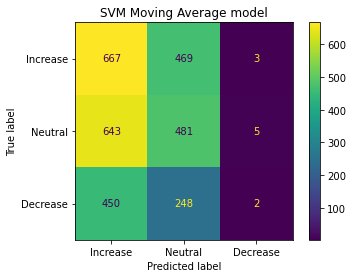

<Figure size 432x288 with 0 Axes>

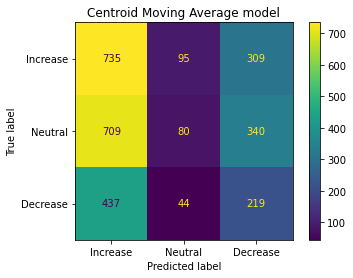

<Figure size 432x288 with 0 Axes>

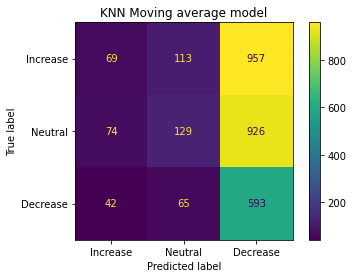

In [94]:
# We can assess the fit with confusion matrices
ax= plt.subplot()
    # Logistic Model 1 :
c_matr_34 = confusion_matrix(Y_MA_test, y_pred_svm)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_34,display_labels=classes).plot()
d.ax_.set_title("SVM Moving Average model")
plt.show()
    # Model 2 :
c_matr_35 = confusion_matrix(Y_MA_test, y_pred_centro)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_35,display_labels=classes).plot()
d.ax_.set_title("Centroid Moving Average model")
plt.show()
    # Model 3 :
c_matr_36 = confusion_matrix(Y_MA_test, y_pred_knn)
plt.clf()
d = ConfusionMatrixDisplay(confusion_matrix=c_matr_36,display_labels=classes).plot()
d.ax_.set_title("KNN Moving average model")
plt.show()

The centroid seems to be better because it seems to predict an acceptable amount of True increase, true decrease and the model seems to be the most accurate.

In [95]:
# Let's do a back test (of course we could have created a function for that but we are missing some time)
# Creating a frame with the closing price and the spread
frame_price = frame_
frame_price['time'] = pd.to_datetime(frame_price['time'], unit='s')   
frame_price.index=pd.to_datetime(frame_price['time'])
frame_price = frame_price[['close','spread']]

# Selecting th prediction
y_predicted = data_pred.iloc[:, 1]
data_y = pd.concat([pd.DataFrame(Y_MA_test), y_predicted], axis =1)
# Ask
frame_price.columns=['ask_price', 'spread']
# Creating the bid
frame_price['bid_price']=frame_price['ask_price'] - frame_price['spread']*point_trade
bt_frame=  pd.merge(frame_price, data_y, left_index=True, right_index=True, how=("right"))
bt_frame['l_ask_price']=bt_frame['ask_price'].shift()
bt_frame['l_bid_price']=bt_frame['bid_price'].shift()
# Waiting
open_sell_position=False 
open_buy_position=False 
# Initial gain 
bt_frame['gain']=0.00000
bt_frame.dropna(inplace = True)
nb_trade = 0
# In all the dataframe (code from the class)
for i in range(0,len(bt_frame)):
    if (bt_frame[data_pred.columns[1]][i]=="Decrease") and not open_sell_position  and not open_buy_position :
        nb_trade=nb_trade+1
        sell_price=bt_frame['l_bid_price'][i]
        tp_sell=bt_frame['l_bid_price'][i]-threshold*point_trade
        sl_sell=bt_frame['l_bid_price'][i]+threshold*point_trade
        open_sell_position=True
    if (bt_frame[data_pred.columns[1]][i]=="Increase") and not open_sell_position and not open_buy_position :
        nb_trade=nb_trade+1
        buy_price=bt_frame['l_ask_price'][i]
        tp_buy=bt_frame['l_ask_price'][i]+threshold*point_trade
        sl_buy=bt_frame['l_ask_price'][i]-threshold*point_trade
        open_buy_position=True
    
    # In case we detected a decrease or an increase
    if open_sell_position:
        offer = sell_price
        if bt_frame['ask_price'][i] <= tp_sell:
            demand = tp_sell
        elif bt_frame['ask_price'][i] >= sl_sell:
            demand = sl_sell         
    if open_buy_position:
        demand = buy_price
        if bt_frame['bid_price'][i] <= sl_buy:
            offer = sl_buy
        elif bt_frame['bid_price'][i] >= tp_buy:
            offer = tp_buy
    if (open_buy_position and not open_sell_position) or (not open_buy_position and open_sell_position):
        # Calculate the gain
        bt_frame['gain'][i] = calculate_gain(offer, demand, standard_lot_value, lot_quantity)
        open_buy_position = False
        open_sell_position = False
bt_frame['tot_gain']=np.cumsum(bt_frame['gain'])
print("\nnb trades: ", nb_trade, ". For a total gain of: ", bt_frame['tot_gain'][len(bt_frame)-1])
print("return of the strat over", bt_frame.index.min(), "to", bt_frame.index.max(), "is about: ",
            round(bt_frame['tot_gain'][len(bt_frame)-1]/amount_invested*100), "%" )

                     ask_price  spread  bid_price EURUSD close Centro MA
time                                                                    
2022-05-05 17:20:00    1.05494       0    1.05494     Increase   Neutral
2022-05-05 17:28:00    1.05489       0    1.05489     Decrease  Decrease
2022-05-05 17:30:00    1.05519       0    1.05519     Increase  Decrease
2022-05-05 17:32:00    1.05487       0    1.05487     Decrease  Decrease
2022-05-05 17:42:00    1.05411       0    1.05411     Decrease   Neutral
...                        ...     ...        ...          ...       ...
2022-05-25 10:44:00    1.06925       0    1.06925     Decrease  Decrease
2022-05-25 10:46:00    1.06907       0    1.06907     Decrease  Decrease
2022-05-25 10:56:00    1.06836       0    1.06836     Decrease   Neutral
2022-05-25 11:04:00    1.06745       0    1.06745     Increase   Neutral
2022-05-25 11:08:00    1.06737       0    1.06737     Increase   Neutral

[2968 rows x 5 columns]

nb trades:  2100 . For a 

In [96]:
# Live trading
trade_executed = 0
while (not infinite_trade and trade_executed < number_of_trade) or infinite_trade:
    data_MA_run = getData_rate(pair_trade, timeframe, 200)
    # Getting the moving average
    data_MA_run = data_MA_run[[pair_trade+' close']]
    data_MA_run['MA5'] = data_MA_run[pair_trade+' close'].rolling(window=5, min_periods=5, center=False).mean()
    data_MA_run['MA10'] = data_MA_run[pair_trade+' close'].rolling(window=10, min_periods=10, center=False).mean()
    data_MA_run['MA20'] = data_MA_run[pair_trade+' close'].rolling(window=20, min_periods=20, center=False).mean()
    data_MA_run['MA50'] = data_MA_run[pair_trade+' close'].rolling(window=50, min_periods=50, center=False).mean()
    data_MA_run['MA100'] = data_MA_run[pair_trade+' close'].rolling(window=100, min_periods=100, center=False).mean()
    # Get the difference
    data_MA_diff_run = pd.DataFrame(None)
    data_MA_diff_run = data_MA_run.diff()
    data_MA_diff_run.dropna(inplace = True)
    # Signals
    data_MA_signals_run = pd.DataFrame(None)
    for i in range(len(data_MA_diff.columns)):
        data_MA_signals_run[data_MA_diff_run.columns[i]] = data_MA_diff_run[data_MA_diff_run.columns[i]]
        data_MA_signals_run[data_MA_diff_run.columns[i]] = 0
    # Reducing threshold because it is hard to get high variations
        data_MA_signals_run[data_MA_diff_run.columns[i]].loc[data_MA_diff_run[data_MA_diff_run.columns[i]]
                                                         >= point_trade*threshold/2] = 1
        data_MA_signals_run[data_MA_diff_run.columns[i]].loc[data_MA_diff_run[data_MA_diff_run.columns[i]] 
                                                         <= -point_trade*threshold/2] = -1
    # Last row of record except closing
    usage_X = data_MA_signals_run.iloc[:,1:].tail(1)
    print(usage_X)
    # Centroid model
    centroid_model.fit(X_MA_train, Y_MA_train)
    y_pred = centroid_model.predict(usage_X)
    if (mt5.positions_total()==0):
        print("\nWe have predicted ", y_pred[0])
        if (y_pred[0]=="Increase"):    
            # Send orders
            r = send_order(pair_trade,lot_quantity,'BUY',magic,threshold, point_trade)
            trade_executed = r + trade_executed
            print(trade_executed)
        if (y_pred[0]=="Decrease"): 
            r =send_order(pair_trade,lot_quantity,'SELL',magic,threshold, point_trade)
            trade_executed = r + trade_executed
            print(trade_executed)
    time.sleep(120)

                     MA5  MA10  MA20  MA50  MA100
time                                             
2022-05-25 11:16:00    0    -1    -1    -1      0

We have predicted  Neutral
                     MA5  MA10  MA20  MA50  MA100
time                                             
2022-05-25 11:18:00    0    -1    -1    -1      0

We have predicted  Neutral
                     MA5  MA10  MA20  MA50  MA100
time                                             
2022-05-25 11:20:00    1    -1    -1    -1      0

We have predicted  Increase

Order successfully placed!
BUY order sent !
1
                     MA5  MA10  MA20  MA50  MA100
time                                             
2022-05-25 11:22:00    0     0    -1    -1      0

We have predicted  Neutral
                     MA5  MA10  MA20  MA50  MA100
time                                             
2022-05-25 11:24:00    0     0    -1    -1      0

We have predicted  Neutral
                     MA5  MA10  MA20  MA50  MA100
time        

In [104]:
# Limit
to_time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin'))+ datetime.timedelta(hours=1)
# Check the trade we made for EURUSD
orders = mt5.history_deals_get(from_time, to_time, group="*EURUSD*") 
if orders==None:
    print("no order on EURUSD ", format(mt5.last_error()))
else :
    # Numberof orders
    print("nb orders EURUSD =",len(orders))
     # list orders
    if len(orders) >0 :
        df=pd.DataFrame(list(orders),columns=orders[0]._asdict().keys())
        df['time'] = pd.to_datetime(df['time'], unit='s')
        my_orders = df.loc[df['magic'] == magic]
        print(my_orders)
        print("Total profit for trades belonging to magical number", magic, " :", my_orders["profit"].sum())

nb orders EURUSD = 18
        ticket       order                time       time_msc  type  entry  \
0   1330108261  1347627606 2022-05-24 22:02:34  1653429754902     1      0   
1   1330110161  1347629920 2022-05-24 22:05:34  1653429934154     0      1   
2   1330111723  1347631682 2022-05-24 22:07:35  1653430055610     1      0   
3   1330112019  1347632001 2022-05-24 22:07:59  1653430079969     0      1   
4   1330115225  1347635635 2022-05-24 22:12:36  1653430356456     1      0   
5   1330116011  1347636492 2022-05-24 22:13:49  1653430429888     0      1   
6   1330123094  1347644748 2022-05-24 22:25:09  1653431109300     1      0   
7   1330123642  1347645330 2022-05-24 22:26:05  1653431165848     0      1   
8   1330124569  1347646392 2022-05-24 22:27:39  1653431259678     0      0   
9   1330124922  1347646751 2022-05-24 22:28:13  1653431293332     1      1   
10  1330126251  1347648234 2022-05-24 22:30:10  1653431410433     0      0   
11  1330126628  1347648662 2022-05-24 22:3

## Conclusion
From what we can say, we have found several strategies that can be used to predict the outcome of the market but they are still not perfect because market is not predictable. Moreover, we think we should run our strategy in the long run to test it because sometimes 10 trades separated by 2 min are not sufficient to tell whether the strategy works (Law of large number in probability).